Mini Project 2: Where Will Dicty Meet?

**Introduction**

Collective migration in Dictyostelium discoideum is a classic example of self-organization in living systems. When nutrients are depleted, thousands of initially independent amoeboid cells begin to communicate via propagating cAMP waves, align their motion, and eventually converge into one or more multicellular aggregation centers. In time-lapse fluorescence movies, this process appears as a rich spatiotemporal pattern: faint wavefronts and subtle intensity changes emerge long before the ultimate aggregation “meeting spot” becomes visually obvious.

In this project, we ask a forward-prediction question: can we predict where the aggregation center(s) will form using only the early portion of each movie? Concretely, given the first 𝐾 frames of a 2D projected sequence, we aim to forecast the final-frame intensity map and, from it, infer the location of the brightest aggregation center. This requires capturing both the temporal evolution of the pattern and the fine spatial structure that distinguishes one potential center from another.

Two technical challenges arise immediately. First, the raw Dicty imaging data are heterogeneous. Different experiments vary in pixel size, field of view, number of z-slices, sampling cadence, and noise level, and often exhibit slow drift of the field of view over time. Directly feeding these raw movies into a model leads to inconsistent inputs and unstable training. To address this, we design a preprocessing pipeline that performs z-projection, spatial rescaling to a common physical resolution, frame-to-frame registration, intensity normalization, and light Gaussian denoising, producing standardized 2D sequences suitable for downstream modeling.

Two technical challenges arise immediately. First, the raw Dicty imaging data are heterogeneous. Different experiments vary in pixel size, field of view, number of z-slices, sampling cadence, and noise level, and often exhibit slow drift of the field of view over time. Directly feeding these raw movies into a model leads to inconsistent inputs and unstable training. To address this, we design a preprocessing pipeline that performs z-projection, spatial rescaling to a common physical resolution, frame-to-frame registration, intensity normalization, and light Gaussian denoising, producing standardized 2D sequences suitable for downstream modeling.

Code Availability: the code of this project is available at https://github.com/Skyrimmm07/STAT5243-Project2-

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install zarr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 124.3 MB/s eta 0:00:00


Imports & seed

In [ ]:
import zarr
import os
import random, numpy as np, matplotlib.pyplot as plt, torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import random
from scipy.ndimage import gaussian_filter
def set_seed(seed=7):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True; torch.backends.cudnn.benchmark=False
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
set_seed(7); DEVICE


'cuda'

In [ ]:
# data_paths
#     "/content/drive/MyDrive/Dicty-Data/Data/mixin_test44/2024-01-17_ERH_23hr_ERH Red FarRed.zarr",
#     "/content/drive/MyDrive/Dicty-Data/Data/mixin_test44/2024-01-17_ERH_23hr_ERH Red FarRed_t_subsampled.zarr",
#     "/content/drive/MyDrive/Dicty-Data/Data/mixin_test57/2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25.zarr",
#     "/content/drive/MyDrive/Dicty-Data/Data/mixin_test57/2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25_t_subsampled.zarr",
#     "/content/drive/MyDrive/Dicty-Data/Data/mixin_test64/ERH_2024-04-04_mixin64_wellC5_10x_overnight_ERH Red FarRed_1.zarr",
#     "/content/drive/MyDrive/Dicty-Data/Data/mixin_test64/ERH_2024-04-04_mixin64_wellC5_10x_overnight_ERH Red FarRed_1_t_subsampled.zarr",


Data Description

In this project we work with three separate microscopy experiments, each recording how Dictyostelium cells move and eventually aggregate. After loading from the original Zarr files and running our preprocessing pipeline, each experiment can be viewed as a 5-D array

$$
(N,\; C,\; T,\; H,\; W)
$$

where  
- $N$ is the number of recorded sequences (videos),  
- $C$ is the number of imaging channels,  
- $T$ is the number of temporal frames per sequence,  
- $H$ and $W$ denote the spatial resolution.

All movies we use are single-channel $(C=1)$， and, after spatial resampling and padding/cropping, share a common frame size of  $(256 \times 256)$ pixels. The experiments mainly differ in how long the recordings are:
- $Experiment1$ medium sequences, about 100 frames per movie.  
- $Experiment2$ long sequences, about 400 frames.
- $Experiment3$ shorter sequences, about 200 frames, but recorded at higher magnification.

For each of these three experiments we also create a temporally subsampled version by keeping every $k$-th frame. These subsampled movies keep the same spatial resolution but have fewer time points, and are later used to test resolution robustness—i.e., how much model performance degrades when we move from high-resolution time series to sparsely sampled ones.

In [ ]:
import numpy as np
import zarr

# Raw zarr paths (full + subsampled)
RAW_PATHS = {
    "exp1_full": "/content/drive/MyDrive/Dicty-Data/Data/mixin_test44/2024-01-17_ERH_23hr_ERH Red FarRed.zarr",
    "exp1_sub":  "/content/drive/MyDrive/Dicty-Data/Data/mixin_test44/2024-01-17_ERH_23hr_ERH Red FarRed_t_subsampled.zarr",

    "exp2_full": "/content/drive/MyDrive/Dicty-Data/Data/mixin_test57/2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25.zarr",
    "exp2_sub":  "/content/drive/MyDrive/Dicty-Data/Data/mixin_test57/2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25_t_subsampled.zarr",

    "exp3_full": "/content/drive/MyDrive/Dicty-Data/Data/mixin_test64/ERH_2024-04-04_mixin64_wellC5_10x_overnight_ERH Red FarRed_1.zarr",
    "exp3_sub":  "/content/drive/MyDrive/Dicty-Data/Data/mixin_test64/ERH_2024-04-04_mixin64_wellC5_10x_overnight_ERH Red FarRed_1_t_subsampled.zarr",
}


def show_raw_shape(label: str, path: str) -> None:
    """Print raw zarr array shape for one experiment."""
    arr = zarr.open(path, mode="r")
    data = np.asarray(arr)
    print(f"{label:9s} | shape = {data.shape}")


print("=== Raw zarr shapes ===")
for label, path in RAW_PATHS.items():
    show_raw_shape(label, path)

=== Raw zarr shapes ===
exp1_full | shape = (100, 1, 32, 256, 256)
exp1_sub  | shape = (34, 1, 32, 256, 256)
exp2_full | shape = (400, 1, 16, 256, 256)
exp2_sub  | shape = (40, 1, 16, 256, 256)


KeyboardInterrupt: 

Data preprocessing



1.   **Z-projection**
For each time point, take a max-intensity projection over the z-axis to convert 3D stacks into 2D frames.

2.   **Spatial rescaling**
Resize all frames to a shared physical pixel size of 2 µm so movies from different experiments are on the same spatial scale.

3.   **Intensity normalization**
Linearly normalize each movie to the 0,10, 10,1 range to reduce brightness differences across experiments.

4.   **Frame registration**
Use phase-correlation–based registration to align frames over time and correct field-of-view drift.


5.   **Gaussian denoising**
Apply light Gaussian smoothing to suppress acquisition noise while keeping the main aggregation patterns.











Functions for preprocess

To keep all movies on a common spatial and intensity scale, we wrap the raw Zarr files in a small preprocessing module:

Experiment configuration.
Each movie is described by an ExperimentConfig (file path, pixel size, z-step, time interval, number of z-slices, label). This lets us handle full-resolution and time-subsampled versions of the same experiment with a single pipeline.

Shape standardization and loading.
The function _standardize_shape converts the raw Zarr array into a canonical (T, Z, H, W) layout and drops extra channel dimensions if present. load_volume then returns this standardized 4-D volume for a given experiment.

Drift correction.
register_sequence aligns all frames to the first frame using phase cross-correlation in the Fourier domain, reducing slow field-of-view drift across time.

Denoising.
denoise_gaussian applies a light Gaussian filter (sigma = 1) to each frame to suppress high-frequency acquisition noise while keeping the main spatial structures.

Main preprocessing step.
The function preprocess performs the full pipeline for one experiment:

Z-max projection over slices to get a 2-D time series (T, H, W).

Optional spatial rescaling so that all movies share the same physical pixel size (TARGET_PIXEL_SIZE = 2.0 µm).

Frame-wise registration with register_sequence.

Global min–max normalization to the [0, 1] range.

Gaussian denoising with denoise_gaussian.
The result is saved as a float32 NumPy array.

Batch preprocessing.
preprocess_all loops over the list of ExperimentConfig objects, runs preprocess for each movie, and writes the outputs to /content/drive/MyDrive/processed/<basename>_preprocessed.npy for later modeling.

In [ ]:
import os
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import zarr
import cv2
from scipy.ndimage import zoom, fourier_shift, gaussian_filter
from skimage.registration import phase_cross_correlation

try:
    # skimage gives better interpolation but fall back to ndimage if unavailable.
    from skimage.transform import resize as sk_resize
except Exception:
    sk_resize = None


# Configs
# -------------------------

@dataclass
class ExperimentConfig:
    path: str
    pixel_size: float  # microns per pixel
    z_step: float      # microns between z slices
    time_interval: float  # seconds (or minutes) between frames
    z_slices: int
    label: str

TARGET_PIXEL_SIZE = 2.0  # microns; used to homogenize spatial scale

configs: List[ExperimentConfig] = [
    ExperimentConfig(
        path="/content/drive/MyDrive/Dicty-Data/Data/mixin_test44/2024-01-17_ERH_23hr_ERH Red FarRed.zarr",
        pixel_size=2.41,
        z_step=2.0,
        time_interval=5.0,
        z_slices=32,
        label="mixin44_full",
    ),
    ExperimentConfig(
        path="/content/drive/MyDrive/Dicty-Data/Data/mixin_test44/2024-01-17_ERH_23hr_ERH Red FarRed_t_subsampled.zarr",
        pixel_size=2.41,
        z_step=2.0,
        time_interval=15.0,
        z_slices=32,
        label="mixin44_subsampled",
    ),
    ExperimentConfig(
        path="/content/drive/MyDrive/Dicty-Data/Data/mixin_test57/2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25.zarr",
        pixel_size=2.41,
        z_step=2.0,
        time_interval=1.0,
        z_slices=16,
        label="mixin57_full",
    ),
    ExperimentConfig(
        path="/content/drive/MyDrive/Dicty-Data/Data/mixin_test57/2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25_t_subsampled.zarr",
        pixel_size=2.41,
        z_step=2.0,
        time_interval=10.0,
        z_slices=16,
        label="mixin57_subsampled",
    ),
    ExperimentConfig(
        path="/content/drive/MyDrive/Dicty-Data/Data/mixin_test64/ERH_2024-04-04_mixin64_wellC5_10x_overnight_ERH Red FarRed_1.zarr",
        pixel_size=1.28,
        z_step=7.28,
        time_interval=1.0,
        z_slices=48,
        label="mixin64_full",
    ),
    ExperimentConfig(
        path="/content/drive/MyDrive/Dicty-Data/Data/mixin_test64/ERH_2024-04-04_mixin64_wellC5_10x_overnight_ERH Red FarRed_1_t_subsampled.zarr",
        pixel_size=1.28,
        z_step=7.28,
        time_interval=10.0,
        z_slices=48,
        label="mixin64_subsampled",
    ),
]

preprocessed_root = Path("/content/drive/MyDrive/processed")


def _standardize_shape(x: np.ndarray, z_slices: int) -> np.ndarray:
    """Ensure array is (T, Z, H, W)."""
    if x.ndim == 5:
        # Possible layouts: (C, T, Z, H, W) or (T, C, Z, H, W)
        if x.shape[0] <= 3:  # channel-first
            x = x[0]
        elif x.shape[1] <= 3:  # channel-second
            x = x[:, 0]
    if x.ndim == 4 and x.shape[1] != z_slices and x.shape[0] == z_slices:
        # (Z, T, H, W) -> (T, Z, H, W)
        x = np.moveaxis(x, 0, 1)
    if x.ndim == 3:
        # Missing z-axis -> add singleton
        x = x[:, None, ...]
    return x

def register_sequence(x: np.ndarray) -> np.ndarray:
    """Align frames to the first frame via phase correlation to reduce drift."""
    ref = x[0]
    aligned = [ref]
    for frame in x[1:]:
        shift, _, _ = phase_cross_correlation(ref, frame, upsample_factor=10)
        frame_fft = np.fft.fftn(frame)
        shifted = np.real(np.fft.ifftn(fourier_shift(frame_fft, shift)))
        aligned.append(shifted)
    return np.stack(aligned, axis=0)

def denoise_gaussian(x: np.ndarray, sigma: float = 1.0) -> np.ndarray:
    """Light Gaussian smoothing per frame to suppress shot noise."""
    if sigma <= 0:
        return x.astype(np.float32)
    return np.stack([gaussian_filter(f, sigma=sigma) for f in x], axis=0).astype(np.float32)

def load_volume(cfg: ExperimentConfig) -> np.ndarray:
    """Load raw zarr and return (T, Z, H, W) single-channel volume."""
    arr = zarr.open(cfg.path, mode="r")
    x = np.asarray(arr)
    x = _standardize_shape(x, cfg.z_slices)
    return x  # (T, Z, H, W) for your data


# -------------------------
# Main preprocess
# -------------------------

def preprocess(cfg: ExperimentConfig, target_px: float = TARGET_PIXEL_SIZE) -> np.ndarray:
    """
    Same pipeline as your classmate's preprocess_zarr:
      1) load zarr (T,1,Z,H,W)
      2) Z-max projection -> (T,H,W)
      3) spatial rescaling via cv2.resize using scale = pixel_size / target_px
      4) frame registration
      5) global min-max normalization to [0,1]
      6) Gaussian smoothing with sigma=1
    """
    import zarr, cv2

    print(f"\nProcessing {cfg.label} from {cfg.path} ...")
    z = zarr.open(cfg.path, mode="r")
    T, C, Z, H, W = z.shape
    print("Raw shape:", z.shape)
    if C != 1:
        print(f"[WARN] C={C} != 1, using first channel only.")

    # 1+2) Z-max projection: proj[t] = max_z z[t,0]
    proj = np.array([z[t, 0].max(axis=0) for t in range(T)], dtype=np.float32)
    print("After Z-max projection:", proj.shape)

    # 3) Spatial rescaling
    scale = cfg.pixel_size / target_px
    if abs(scale - 1.0) > 1e-3:
        print(f"Rescaling with factor {scale:.3f} (pixel_size {cfg.pixel_size} -> {target_px})")
        proj_rescaled = np.array(
            [
                cv2.resize(p, dsize=None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
                for p in proj
            ],
            dtype=np.float32,
        )
    else:
        print("No spatial rescaling needed.")
        proj_rescaled = proj

    print("After rescaling:", proj_rescaled.shape)

    # 4) Registration
    print("Performing frame registration ...")
    proj_registered = register_sequence(proj_rescaled)

    # 5) Global min-max normalization
    v_min = float(proj_registered.min())
    v_max = float(proj_registered.max())
    normed = (proj_registered - v_min) / (v_max - v_min + 1e-6)
    normed = np.clip(normed, 0.0, 1.0)

    # 6) Gaussian smoothing
    denoised = denoise_gaussian(normed, sigma=1.0)  # gaussian_filter(sigma=1)

    print(
        "Final processed shape:", denoised.shape,
        "| value range:", float(denoised.min()), "->", float(denoised.max())
    )
    return denoised.astype(np.float32)


# -------------------------

def preprocess_all(experiments: List[ExperimentConfig]) -> List[np.ndarray]:
    """
    Run preprocess() for each ExperimentConfig and save to
    /content/drive/MyDrive/processed/<basename>_preprocessed.npy

    Return list of arrays in the same order as `experiments`.
    """
    os.makedirs(preprocessed_root, exist_ok=True)
    processed: List[np.ndarray] = []

    for cfg in experiments:
        arr = preprocess(cfg, target_px=TARGET_PIXEL_SIZE)

        basename = os.path.basename(cfg.path)            # e.g. "...Red FarRed.zarr" -> name
        fname = basename.replace(".zarr", "_preprocessed.npy")
        out_path = preprocessed_root / fname

        np.save(out_path, arr)
        print("Saved:", out_path)

        processed.append(arr)

    return processed


In [ ]:
processed = preprocess_all(configs)
for cfg, arr in zip(configs, processed):
    print(cfg.label, arr.shape)



Processing mixin44_full from /content/drive/MyDrive/Dicty-Data/Data/mixin_test44/2024-01-17_ERH_23hr_ERH Red FarRed.zarr ...
Raw shape: (100, 1, 32, 256, 256)
After Z-max projection: (100, 256, 256)
Rescaling with factor 1.205 (pixel_size 2.41 -> 2.0)
After rescaling: (100, 308, 308)
Performing frame registration ...
Final processed shape: (100, 308, 308) | value range: 0.031151266768574715 -> 0.5324601531028748
Saved: /content/drive/MyDrive/processed/2024-01-17_ERH_23hr_ERH Red FarRed_preprocessed.npy

Processing mixin44_subsampled from /content/drive/MyDrive/Dicty-Data/Data/mixin_test44/2024-01-17_ERH_23hr_ERH Red FarRed_t_subsampled.zarr ...
Raw shape: (34, 1, 32, 256, 256)
After Z-max projection: (34, 256, 256)
Rescaling with factor 1.205 (pixel_size 2.41 -> 2.0)
After rescaling: (34, 308, 308)
Performing frame registration ...
Final processed shape: (34, 308, 308) | value range: 0.03109045699238777 -> 0.7529369592666626
Saved: /content/drive/MyDrive/processed/2024-01-17_ERH_23hr_

Sequence modeling utilities.

We first build a small toolkit that turns each preprocessed movie into supervised training data for “next-frame prediction”. Using a sliding window of
$𝐾$consecutive frames, we construct input–target pairs (past
$𝐾$ frames → next frame), split them into train/validation sets, and train models with a shared training loop. On top of that, we add simple helpers to predict the final frame from the last
$𝐾$ inputs and to visualize / compare aggregation centers between the ground-truth and predicted final frames.

In [ ]:
# ============================================
# Sequence dataset + training / inference utils
# (use K previous frames to predict next frame)
# ============================================

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from skimage.feature import peak_local_max
import matplotlib.pyplot as plt

# Device config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Default number of context frames
K_FRAMES: int = 8


class NextFrameDataset(Dataset):
    """
    Build (input, target) pairs from a 2D time-lapse sequence.

    Given sequence arr_2d with shape (T, H, W),
    each sample uses K consecutive frames to predict the (K+1)-th:

        X[i] : frames i .. i+K-1   -> shape (K, 1, H, W)
        y[i] : frame i+K           -> shape (1, H, W)

    When exclude_last=True, the very last frame of the movie
    is never used as a target, to avoid leaking the test frame
    into the supervised training set.
    """
    def __init__(self, arr_2d: np.ndarray, K: int = K_FRAMES, exclude_last: bool = True) -> None:
        arr = arr_2d.astype(np.float32)
        total = arr.shape[0]

        # How many sliding windows of length K we can extract
        n_windows = total - K
        if exclude_last:
            # Reserve the final frame of the movie for test-time evaluation only
            n_windows -= 1

        # Build sliding windows
        X_list = [arr[i:i+K] for i in range(n_windows)]   # (K, H, W)
        y_list = [arr[i+K]   for i in range(n_windows)]   # (H, W)

        X = np.stack(X_list, axis=0)   # (N, K, H, W)
        y = np.stack(y_list, axis=0)   # (N, H, W)

        # Add a channel dimension so that models can use Conv2d
        self.X = X[:, :, None, ...]    # (N, K, 1, H, W)
        self.y = y[:, None, ...]       # (N, 1, H, W)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, idx: int):
        # copy() avoids strange view warnings when using DataLoader with num_workers>0
        x = torch.from_numpy(self.X[idx].copy())
        y = torch.from_numpy(self.y[idx].copy())
        return x, y


def fit_next_frame_model(
    model: nn.Module,
    arr_train: np.ndarray,
    K: int = K_FRAMES,
    batch_size: int = 8,
    epochs: int = 20,
    lr: float = 1e-3,
    exclude_last: bool = True,
) -> nn.Module:
    """
    Train a model to predict the next frame from K previous frames.

    - arr_train: preprocessed movie, shape (T, H, W), values in [0, 1]
    - model: any nn.Module that takes (B, K, 1, H, W) and outputs (B, 1, H, W)
    """

    ds = NextFrameDataset(arr_train, K=K, exclude_last=exclude_last)
    n_train = int(0.8 * len(ds))
    n_val = len(ds) - n_train

    train_ds, val_ds = random_split(
        ds,
        [n_train, n_val],
        generator=torch.Generator().manual_seed(0),
    )

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size * 2)

    model = model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    loss_fn = nn.MSELoss()

    best_val = float("inf")
    best_state = None

    for epoch in range(1, epochs + 1):
        # ---- training ----
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()

            train_loss += loss.item() * xb.size(0)

        train_loss /= len(train_ds)

        # ---- validation ----
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(DEVICE)
                yb = yb.to(DEVICE)
                pred = model(xb)
                val_loss += loss_fn(pred, yb).item() * xb.size(0)

        val_loss /= len(val_ds)

        if val_loss < best_val:
            best_val = val_loss
            # store weights on CPU to avoid keeping multiple GPU copies
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}

        if epoch % 5 == 0:
            print(f"Epoch {epoch:02d}  train {train_loss:.6f}  val {val_loss:.6f}")

    # restore best validation checkpoint
    if best_state is not None:
        model.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})

    return model


@torch.no_grad()
def predict_last_frame(
    model: nn.Module,
    arr_2d: np.ndarray,
    K: int = K_FRAMES,
) -> np.ndarray:
    """
    Use the last K frames of a sequence to predict the final frame.

    - arr_2d: (T, H, W), full movie
    - returns: (H, W) array in [0, 1]
    """
    model.eval()

    # Take last K frames, add channel + batch axes
    window = arr_2d[-K:].astype(np.float32)   # (K, H, W)
    window = window[:, None, ...]            # (K, 1, H, W)
    window = window[None, ...]               # (1, K, 1, H, W)

    x = torch.from_numpy(window).to(DEVICE)
    pred = model(x).cpu().squeeze().numpy()  # (H, W)

    return np.clip(pred, 0.0, 1.0)


def detect_centers(
    img: np.ndarray,
    threshold_rel: float = 0.7,
    min_distance: int = 10,
    smooth_sigma: float = 1.0,
) -> np.ndarray:
    """
    Detect aggregation centers as local maxima above a relative threshold.

    Returns an array of shape (n_peaks, 2) with (row, col) coordinates.
    """
    smoothed = gaussian_filter(img, sigma=smooth_sigma)
    coords = peak_local_max(
        smoothed,
        min_distance=min_distance,
        threshold_rel=threshold_rel,
    )
    return coords


def get_brightest_point(img: np.ndarray) -> Tuple[int, int]:
    """
    Return the (row, col) location of the globally brightest pixel.
    """
    idx = int(np.argmax(img))
    y, x = np.unravel_index(idx, img.shape)
    return int(y), int(x)


def plot_centers_with_brightest(
    gt: np.ndarray,
    pred: np.ndarray,
    thr: float = 0.7,
):
    """
    Visualize detected centers and the brightest pixel
    for both ground truth and predicted final frames.
    """
    gt_c = detect_centers(gt, threshold_rel=thr)
    pr_c = detect_centers(pred, threshold_rel=thr)

    gt_pt = get_brightest_point(gt)
    pr_pt = get_brightest_point(pred)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Ground truth
    ax = axes[0]
    ax.imshow(gt, cmap="gray")
    if len(gt_c) > 0:
        ax.scatter(gt_c[:, 1], gt_c[:, 0], s=40, marker="x", label="GT centers")
    ax.scatter(gt_pt[1], gt_pt[0], s=80, marker="o", label="GT brightest")
    ax.set_title(f"Ground Truth (n={len(gt_c)})")
    ax.axis("off")
    ax.legend(loc="upper right")

    # Prediction
    ax = axes[1]
    ax.imshow(pred, cmap="gray")
    if len(pr_c) > 0:
        ax.scatter(pr_c[:, 1], pr_c[:, 0], s=40, marker="x", label="Pred centers")
    ax.scatter(pr_pt[1], pr_pt[0], s=80, marker="o", label="Pred brightest")
    ax.set_title(f"Prediction (n={len(pr_c)})")
    ax.axis("off")
    ax.legend(loc="upper right")

    plt.tight_layout()
    plt.show()

    return gt_c, pr_c, gt_pt, pr_pt


Loading Processed Data

In [ ]:
from pathlib import Path
from typing import Dict, Tuple

import numpy as np

# Root directory where all preprocessed movies are stored
PROCESSED_ROOT = Path("/content/drive/MyDrive/processed")

# Stems correspond to the original Zarr file basenames
MOVIE_STEMS: Dict[str, str] = {
    "exp1": "2024-01-17_ERH_23hr_ERH Red FarRed",
    "exp2": "2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25",
    "exp3": "ERH_2024-04-04_mixin64_wellC5_10x_overnight_ERH Red FarRed_1",
}


def load_preprocessed_movie(stem: str, root: Path = PROCESSED_ROOT) -> np.ndarray:
    """
    Load a preprocessed movie with shape (T, H, W) from disk.

    Files are expected to be named:
        <stem>_preprocessed.npy
    under the given root directory.
    """
    path = root / f"{stem}_preprocessed.npy"
    arr = np.load(path)
    if arr.ndim != 3:
        raise ValueError(f"Expected 3D array (T,H,W), got shape {arr.shape} from {path}")
    return arr.astype(np.float32)


def load_experiments() -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Convenience helper to load the three main experiments as 3D arrays.

    Returns:
        (arr_2d_exp1, arr_2d_exp2, arr_2d_exp3)
    """
    arr_2d_exp1 = load_preprocessed_movie(MOVIE_STEMS["exp1"])
    arr_2d_exp2 = load_preprocessed_movie(MOVIE_STEMS["exp2"])
    arr_2d_exp3 = load_preprocessed_movie(MOVIE_STEMS["exp3"])
    print("Loaded shapes:",
          arr_2d_exp1.shape,
          arr_2d_exp2.shape,
          arr_2d_exp3.shape)
    return arr_2d_exp1, arr_2d_exp2, arr_2d_exp3


def get_final_frames(
    arr_2d_exp1: np.ndarray,
    arr_2d_exp2: np.ndarray,
    arr_2d_exp3: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Extract the final frame (ground-truth aggregation pattern)
    from each experiment.

    Each input must be a movie of shape (T, H, W).
    """
    gt_exp1 = arr_2d_exp1[-1].copy()
    gt_exp2 = arr_2d_exp2[-1].copy()
    gt_exp3 = arr_2d_exp3[-1].copy()
    return gt_exp1, gt_exp2, gt_exp3


# -------- Example usage --------

# Load three preprocessed movies
arr_2d_exp1, arr_2d_exp2, arr_2d_exp3 = load_experiments()

# Final ground-truth frames (H, W) for each experiment
gt_exp1, gt_exp2, gt_exp3 = get_final_frames(arr_2d_exp1, arr_2d_exp2, arr_2d_exp3)

print("GT shapes:",
      gt_exp1.shape,
      gt_exp2.shape,
      gt_exp3.shape)


Loaded shapes: (100, 308, 308) (400, 308, 308) (200, 164, 164)
GT shapes: (308, 308) (308, 308) (164, 164)


Evaluation

To tackle the frame-prediction task, we implement three spatiotemporal models with different ways of combining space and time information.




1.   **SpatialLSTM**
We first pass each frame through a small CNN encoder to obtain a high-resolution feature map.
These feature maps are then spatially pooled into a coarse grid so that the feature dimensionality stays manageable.
The sequence of grid features across time is fed into an LSTM, which summarizes the temporal dynamics.
The final LSTM state is reshaped back into a spatial grid, upsampled to the original resolution, and fused with the last input frame’s feature map.
A convolutional decoder then transforms this fused representation into the predicted next frame.
2.   **SpatialTransformer**
Similar to the SpatialLSTM model, each frame is encoded by a CNN and pooled into a compact spatial grid.
For every grid cell, we treat its feature values over time as a short sequence and process it with a Transformer encoder, using learned temporal positional embeddings to keep track of frame order.
The Transformer output is mapped back to a grid, upsampled to full resolution, and combined with the last frame’s feature map.
A convolutional decoder uses this fused representation to generate the final predicted frame.
3.   **CNN baseline (TinyCNN)**:
As a purely spatial baseline, we stack the K input frames into a short “time” dimension and process them with a single 3D convolution that spans all K frames at once.
This produces a 2D feature map that already mixes information from the whole input window.
A lightweight 2D convolutional head then maps this feature map to a single-channel prediction of the next frame, without any explicit recurrent or attention-based sequence modeling.












In [ ]:
# ============================================
# Spatiotemporal models
# (SpatialLSTM, SpatialTransformer, CNN baseline)
# ============================================

from typing import Tuple

import torch
from torch import nn
import torch.nn.functional as F


class SpatialLSTM(nn.Module):
    """
    Spatiotemporal model based on:
      - per-frame CNN encoder -> spatial grid
      - LSTM over the sequence of grids
      - map LSTM hidden state back to a spatial grid
      - optionally fuse with the last frame's high-res feature map
      - decode to predict the next frame

    Expected input:  x : (B, K, 1, H, W)
    Output:          y : (B, 1, H, W)
    """

    def __init__(
        self,
        K: int,
        hidden_dim: int = 64,
        grid: Tuple[int, int] = (8, 8),
        z_channels: int = 64,
        fuse_last_frame: bool = True,
    ) -> None:
        super().__init__()
        gH, gW = grid
        self.K = K
        self.gH, self.gW = gH, gW
        self.hidden_dim = hidden_dim
        self.Cenc = 32
        self.Cz = z_channels
        self.fuse_last_frame = fuse_last_frame

        # Per-frame encoder to obtain high-resolution feature maps
        self.cnn_enc = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, self.Cenc, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        # Spatial pooling to form a compact grid (avoids huge feature vectors)
        self.spa_pool = nn.AdaptiveAvgPool2d((gH, gW))

        # LSTM over the sequence of flattened grids
        lstm_in_dim = self.Cenc * gH * gW
        self.lstm = nn.LSTM(
            input_size=lstm_in_dim,
            hidden_size=hidden_dim,
            batch_first=True,
        )

        # Map the time-encoded vector back to a spatial grid representation
        self.fc_time2grid = nn.Linear(hidden_dim, self.Cz * gH * gW)

        # Decoder: fuse (optionally) with last frame features, then predict next frame
        dec_in_ch = self.Cz + (self.Cenc if self.fuse_last_frame else 0)
        self.conv_dec = nn.Sequential(
            nn.Conv2d(dec_in_ch, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, kernel_size=1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, K, 1, H, W)
        """
        B, K, _, H, W = x.shape
        assert K == self.K, f"Expected K={self.K}, got {K}"

        seq_vectors = []
        last_feat_map: torch.Tensor | None = None

        # Encode each frame with CNN, pool to grid, flatten to vector
        for t in range(K):
            f_map = self.cnn_enc(x[:, t])              # (B, Cenc, H, W)
            if t == K - 1:
                last_feat_map = f_map                  # store last frame's high-res map
            f_grid = self.spa_pool(f_map)              # (B, Cenc, gH, gW)
            f_vec = f_grid.flatten(start_dim=1)        # (B, Cenc*gH*gW)
            seq_vectors.append(f_vec)

        V = torch.stack(seq_vectors, dim=1)            # (B, K, Cenc*gH*gW)

        # Temporal modeling via LSTM
        lstm_out, _ = self.lstm(V)                     # (B, K, hidden_dim)
        z = lstm_out[:, -1]                            # (B, hidden_dim) final time step

        # Convert LSTM state back to a spatial grid
        z_grid = self.fc_time2grid(z)                  # (B, Cz*gH*gW)
        z_grid = z_grid.view(B, self.Cz, self.gH, self.gW)  # (B, Cz, gH, gW)

        # Upsample grid to full resolution
        z_up = F.interpolate(
            z_grid,
            size=(H, W),
            mode="bilinear",
            align_corners=False,
        )                                              # (B, Cz, H, W)

        if self.fuse_last_frame and last_feat_map is not None:
            dec_in = torch.cat([z_up, last_feat_map], dim=1)   # (B, Cz+Cenc, H, W)
        else:
            dec_in = z_up                                      # (B, Cz, H, W)

        out = self.conv_dec(dec_in)                     # (B, 1, H, W)
        return out


class SpatialTransformer(nn.Module):
    """
    Spatiotemporal model based on:
      - per-frame CNN encoder -> spatial grid
      - Transformer encoder applied independently to each spatial cell's
        temporal sequence (with time positional embeddings)
      - Fuse with last frame feature map and decode to predict next frame.

    Expected input:  x : (B, K, 1, H, W)
    Output:          y : (B, 1, H, W)
    """

    def __init__(
        self,
        K: int,
        d_model: int = 64,
        nhead: int = 4,
        num_layers: int = 2,
        grid: Tuple[int, int] = (8, 8),
        fuse_last_frame: bool = True,
        use_time_pos: bool = True,
    ) -> None:
        super().__init__()
        gH, gW = grid
        self.K = K
        self.d_model = d_model
        self.gH, self.gW = gH, gW
        self.fuse_last_frame = fuse_last_frame
        self.use_time_pos = use_time_pos

        # Per-frame CNN encoder to obtain a d_model-channel feature map
        self.cnn_enc = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, d_model, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        # Spatial pooling to create a compact grid
        self.spa_pool = nn.AdaptiveAvgPool2d((gH, gW))

        # Learnable time positional encoding (same for all spatial cells)
        self.time_pos = nn.Parameter(torch.randn(1, K, d_model))

        # Transformer encoder over time for each spatial location
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(
            enc_layer,
            num_layers=num_layers,
        )

        # Decoder: combine time-encoded grid with last-frame feature map
        dec_in_ch = d_model + (d_model if fuse_last_frame else 0)
        self.conv_dec = nn.Sequential(
            nn.Conv2d(dec_in_ch, max(32, d_model), kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(max(32, d_model), 1, kernel_size=1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, K, 1, H, W)
        """
        B, K, _, H, W = x.shape
        assert K == self.K, f"Expected K={self.K}, got {K}"

        feat_maps: list[torch.Tensor] = []
        grid_list: list[torch.Tensor] = []

        # Per-frame encoding and spatial pooling
        for t in range(K):
            f_map = self.cnn_enc(x[:, t])            # (B, d_model, H, W)
            feat_maps.append(f_map)
            f_grid = self.spa_pool(f_map)            # (B, d_model, gH, gW)
            grid_list.append(f_grid)

        # Stack over time: (B, K, d_model, gH, gW)
        Fg = torch.stack(grid_list, dim=1)

        # Rearrange to treat each spatial cell as its own temporal sequence:
        # (B, K, d_model, gH, gW) -> (B, gH, gW, K, d_model) -> (B*gH*gW, K, d_model)
        Fg_seq = Fg.permute(0, 3, 4, 1, 2).contiguous()
        Fg_seq = Fg_seq.view(B * self.gH * self.gW, K, self.d_model)

        # Add temporal positional encoding
        if self.use_time_pos:
            Fg_seq = Fg_seq + self.time_pos[:, :K, :]

        # Transformer over time axis
        Z = self.transformer(Fg_seq)                # (B*gH*gW, K, d_model)
        Z_last = Z[:, -1, :]                        # (B*gH*gW, d_model)

        # Map back to a (B, d_model, gH, gW) grid
        Z_grid = Z_last.view(B, self.gH, self.gW, self.d_model)
        Z_grid = Z_grid.permute(0, 3, 1, 2).contiguous()   # (B, d_model, gH, gW)

        # Upsample grid to full resolution
        Z_up = F.interpolate(
            Z_grid,
            size=(H, W),
            mode="bilinear",
            align_corners=False,
        )                                               # (B, d_model, H, W)

        # Optionally fuse with last frame features
        if self.fuse_last_frame:
            f_last = feat_maps[-1]                      # (B, d_model, H, W)
            dec_in = torch.cat([Z_up, f_last], dim=1)   # (B, 2*d_model, H, W)
        else:
            dec_in = Z_up                               # (B, d_model, H, W)

        out = self.conv_dec(dec_in)                     # (B, 1, H, W)
        return out


class TinyCNN(nn.Module):
    """
    Simple 3D+2D convolutional baseline:

    - Treat the K input frames as a short "depth" dimension.
    - A single Conv3d with temporal kernel size K collapses time
      into feature channels.
    - A small 2D conv head predicts the next frame.

    Expected input:  x : (B, K, 1, H, W)
    Output:          y : (B, 1, H, W)
    """

    def __init__(self, K: int) -> None:
        super().__init__()
        self.K = K

        # Encodes across the entire time window in one Conv3d
        self.enc3d = nn.Sequential(
            nn.Conv3d(
                in_channels=1,
                out_channels=8,
                kernel_size=(K, 3, 3),
                padding=(0, 1, 1),
            ),
            nn.ReLU(inplace=True),
        )

        # 2D head to map spatial features to 1-channel output
        self.head2d = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 1, kernel_size=1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, K, 1, H, W)
        """
        B, K, C, H, W = x.shape
        assert K == self.K, f"Expected K={self.K}, got {K}"
        assert C == 1, f"Expected 1 channel, got {C}"

        # Conv3d expects (B, C, D, H, W); here D is the time dimension
        x_3d = x.permute(0, 2, 1, 3, 4)           # (B, 1, K, H, W)
        z = self.enc3d(x_3d)                      # (B, 8, 1, H, W)
        z = z.squeeze(2)                          # (B, 8, H, W)
        out = self.head2d(z)                      # (B, 1, H, W)
        return out


SpatialLSTM.

Overall, the SpatialLSTM clearly improves over a purely spatial baseline: it can usually identify the correct aggregation region and often lands very close to the annotated center. At the same time, the qualitative plots reveal two limitations: (1) the model tends to predict multiple comparable peaks instead of a single sharp maximum, and (2) localization becomes less reliable in experiments with noisier patterns or lower spatial resolution. These observations are consistent with the later quantitative results on center error and robustness, and highlight that better spatial regularization or explicit center-prediction heads might be needed if precise single-pixel localization is the main goal.

Loaded shapes: (100, 308, 308) (400, 308, 308) (200, 164, 164)
Movies: (100, 308, 308) (400, 308, 308) (200, 164, 164)
GT frames: (308, 308) (308, 308) (164, 164)

== SpatialLSTM: Training exp1 ==
Epoch 05  train 0.000161  val 0.000155
Epoch 10  train 0.000065  val 0.000073
== SpatialLSTM: Predict exp1 ==

== SpatialLSTM: Training exp2 ==
Epoch 05  train 0.000191  val 0.000200
Epoch 10  train 0.000189  val 0.000194
== SpatialLSTM: Predict exp2 ==

== SpatialLSTM: Training exp3 ==
Epoch 05  train 0.000242  val 0.000229
Epoch 10  train 0.000178  val 0.000175
== SpatialLSTM: Predict exp3 ==

== SpatialLSTM: centers for exp1 ==


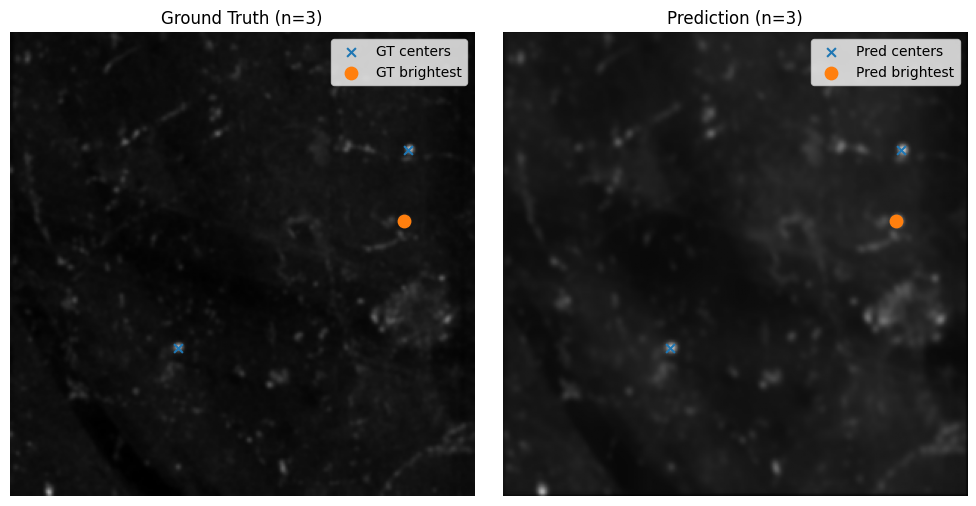

[exp1] Ground truth center: (125, 261)
[exp1] Predicted center:    (125, 261)

== SpatialLSTM: centers for exp2 ==


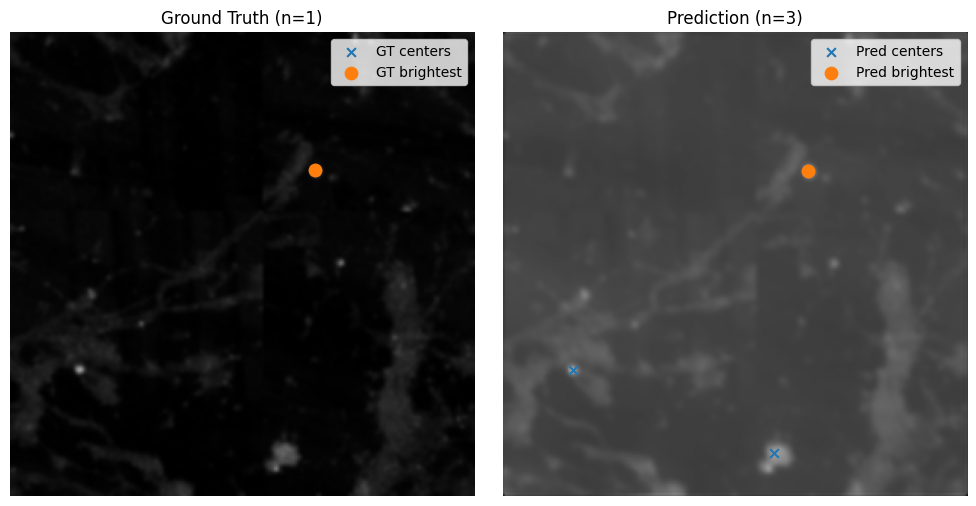

[exp2] Ground truth center: (91, 202)
[exp2] Predicted center:    (92, 202)

== SpatialLSTM: centers for exp3 ==


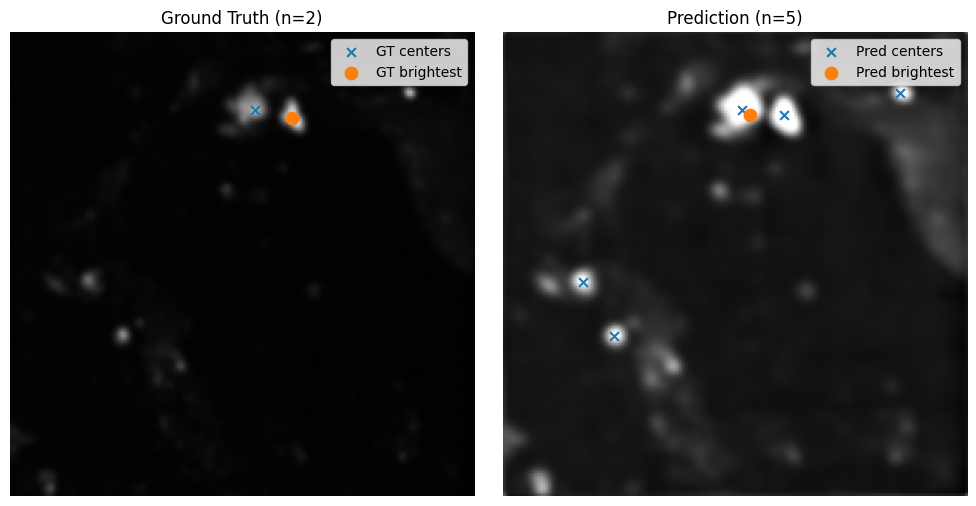

[exp3] Ground truth center: (30, 99)
[exp3] Predicted center:    (29, 87)


In [ ]:
# ============================================
# SpatialLSTM: train on 3 experiments & predict final frame
# ============================================

# Step 1: load preprocessed movies and ground-truth final frames
arr_2d_exp1, arr_2d_exp2, arr_2d_exp3 = load_experiments()
gt_exp1, gt_exp2, gt_exp3 = get_final_frames(arr_2d_exp1, arr_2d_exp2, arr_2d_exp3)

print("Movies:", arr_2d_exp1.shape, arr_2d_exp2.shape, arr_2d_exp3.shape)
print("GT frames:", gt_exp1.shape, gt_exp2.shape, gt_exp3.shape)

# Use the same K as in your dataset utilities
K = 8   # typically 8


# ---------- Experiment 1 ----------
print("\n== SpatialLSTM: Training exp1 ==")
model_lstm_exp1 = SpatialLSTM(
    K=K,
    hidden_dim=64,
    grid=(8, 8),
    z_channels=64,
    fuse_last_frame=True,
).to(DEVICE)

model_lstm_exp1 = fit_next_frame_model(
    model=model_lstm_exp1,
    arr_train=arr_2d_exp1,
    K=K,
    batch_size=8,
    epochs=10,      # 10 epochs
    lr=1e-3,
    exclude_last=True,
)

print("== SpatialLSTM: Predict exp1 ==")
pred_lstm_exp1 = predict_last_frame(
    model=model_lstm_exp1,
    arr_2d=arr_2d_exp1,
    K=K,
)

# ---------- Experiment 2 ----------
print("\n== SpatialLSTM: Training exp2 ==")
model_lstm_exp2 = SpatialLSTM(
    K=K,
    hidden_dim=64,
    grid=(8, 8),
    z_channels=64,
    fuse_last_frame=True,
).to(DEVICE)

model_lstm_exp2 = fit_next_frame_model(
    model=model_lstm_exp2,
    arr_train=arr_2d_exp2,
    K=K,
    batch_size=8,
    epochs=10,
    lr=1e-3,
    exclude_last=True,
)

print("== SpatialLSTM: Predict exp2 ==")
pred_lstm_exp2 = predict_last_frame(
    model=model_lstm_exp2,
    arr_2d=arr_2d_exp2,
    K=K,
)

# ---------- Experiment 3 ----------
print("\n== SpatialLSTM: Training exp3 ==")
model_lstm_exp3 = SpatialLSTM(
    K=K,
    hidden_dim=64,
    grid=(8, 8),
    z_channels=64,
    fuse_last_frame=True,
).to(DEVICE)

model_lstm_exp3 = fit_next_frame_model(
    model=model_lstm_exp3,
    arr_train=arr_2d_exp3,
    K=K,
    batch_size=8,
    epochs=10,
    lr=1e-3,
    exclude_last=True,
)

print("== SpatialLSTM: Predict exp3 ==")
pred_lstm_exp3 = predict_last_frame(
    model=model_lstm_exp3,
    arr_2d=arr_2d_exp3,
    K=K,
)


# ---------- Visualize centers + brightest points ----------
print("\n== SpatialLSTM: centers for exp1 ==")
gt_c1, pr_c_lstm1, gt_pt1, pr_pt_lstm1 = plot_centers_with_brightest(
    gt=gt_exp1,
    pred=pred_lstm_exp1,
    thr=0.7,
)
print(f"[exp1] Ground truth center: {gt_pt1}")
print(f"[exp1] Predicted center:    {pr_pt_lstm1}")

print("\n== SpatialLSTM: centers for exp2 ==")
gt_c2, pr_c_lstm2, gt_pt2, pr_pt_lstm2 = plot_centers_with_brightest(
    gt=gt_exp2,
    pred=pred_lstm_exp2,
    thr=0.7,
)
print(f"[exp2] Ground truth center: {gt_pt2}")
print(f"[exp2] Predicted center:    {pr_pt_lstm2}")

print("\n== SpatialLSTM: centers for exp3 ==")
gt_c3, pr_c_lstm3, gt_pt3, pr_pt_lstm3 = plot_centers_with_brightest(
    gt=gt_exp3,
    pred=pred_lstm_exp3,
    thr=0.7,
)
print(f"[exp3] Ground truth center: {gt_pt3}")
print(f"[exp3] Predicted center:    {pr_pt_lstm3}")


SpatialTransformer



For the SpatialTransformer, the qualitative and quantitative signals are pretty encouraging. The training/validation curves stay low and stable across all three experiments, and the final‐frame visualizations show that the model consistently locks onto the correct aggregation center: in exp1 and exp3 the predicted brightest point exactly matches the ground-truth coordinate, and in exp2 the error is only about one pixel. Compared with the SpatialLSTM, the Transformer’s predictions look slightly smoother and sometimes a bit more “washed out” in the background, but the peak around the true center is still very sharp. One limitation is that additional local maxima are sometimes weaker than in the ground truth, suggesting that while the Transformer is very good at getting the main meeting spot correct, it may under-represent secondary centers or fine-scale texture. Overall, it confirms that modeling each spatial cell’s temporal sequence with self-attention is effective for precise center localization, but there is still room to improve the richness of the predicted intensity patterns.


== SpatialTransformer: Training exp1 ==
Epoch 05  train 0.000655  val 0.000337
Epoch 10  train 0.000203  val 0.000123
== SpatialTransformer: Predict exp1 ==

== SpatialTransformer: Training exp2 ==
Epoch 05  train 0.000213  val 0.000199
Epoch 10  train 0.000199  val 0.000197
== SpatialTransformer: Predict exp2 ==

== SpatialTransformer: Training exp3 ==
Epoch 05  train 0.000180  val 0.000075
Epoch 10  train 0.000057  val 0.000048
== SpatialTransformer: Predict exp3 ==

== SpatialTransformer: centers for exp1 ==


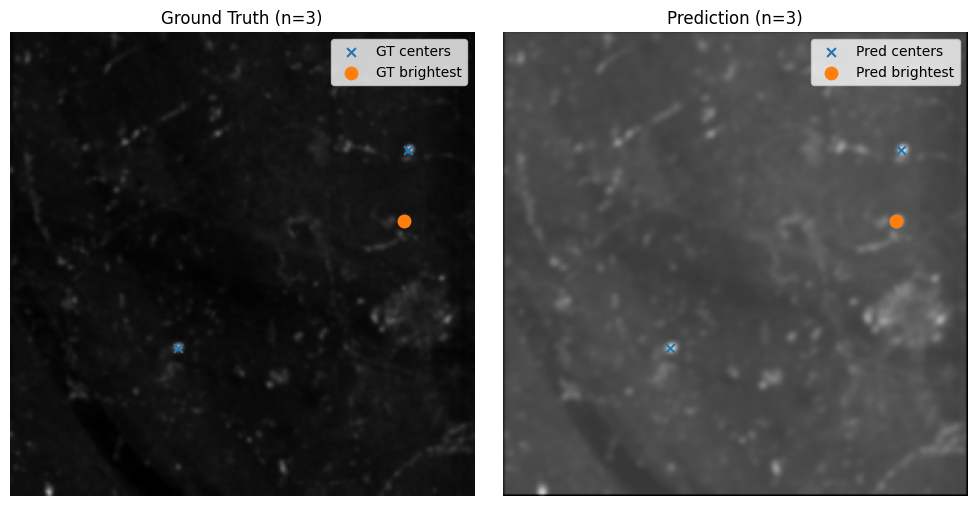

[exp1] Ground truth center: (125, 261)
[exp1] Predicted center:    (125, 261)

== SpatialTransformer: centers for exp2 ==


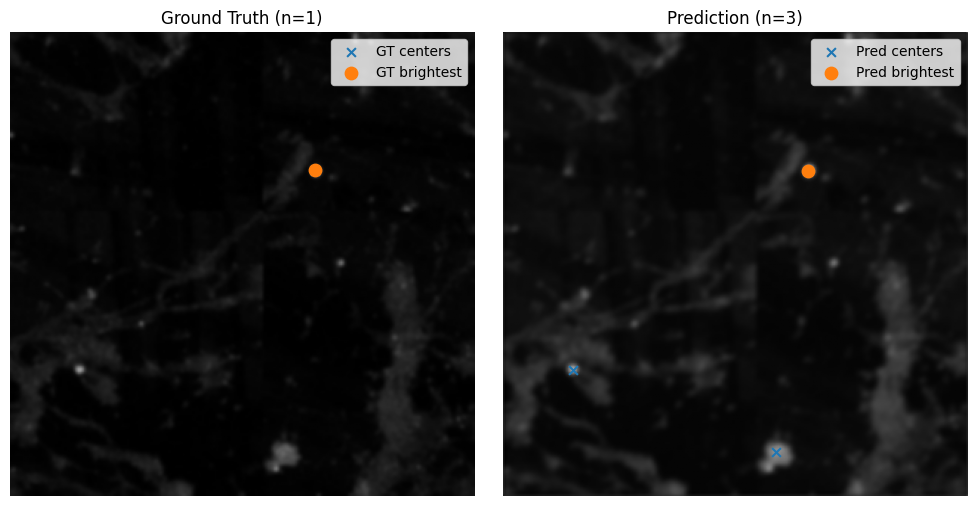

[exp2] Ground truth center: (91, 202)
[exp2] Predicted center:    (92, 202)

== SpatialTransformer: centers for exp3 ==


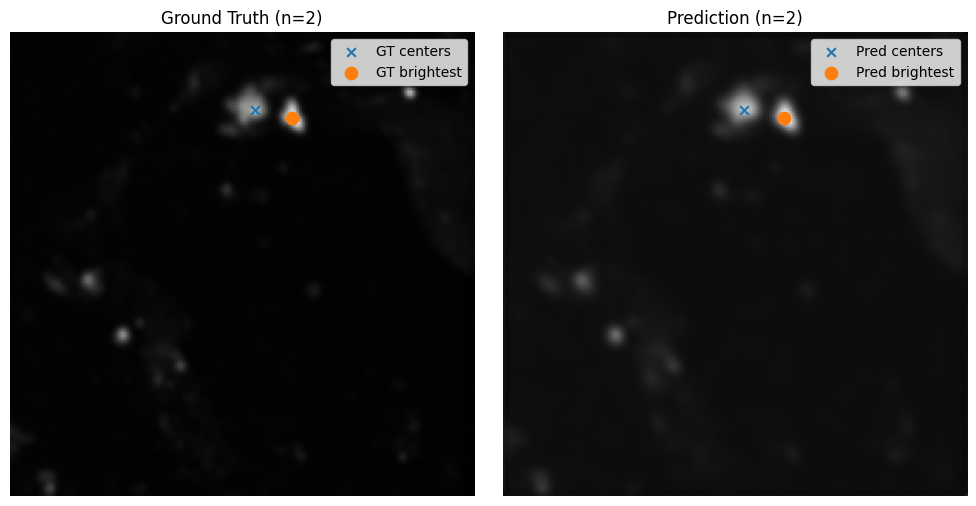

[exp3] Ground truth center: (30, 99)
[exp3] Predicted center:    (30, 99)


In [ ]:
# ============================================
# SpatialTransformer: train on 3 experiments & predict final frame (10 epochs)
# ============================================


# ---------- Experiment 1 ----------
print("\n== SpatialTransformer: Training exp1 ==")
model_tr_exp1 = SpatialTransformer(
    K=K,
    d_model=64,
    nhead=4,
    num_layers=2,
    grid=(8, 8),
    fuse_last_frame=True,
    use_time_pos=True,
).to(DEVICE)

model_tr_exp1 = fit_next_frame_model(
    model=model_tr_exp1,
    arr_train=arr_2d_exp1,
    K=K,
    batch_size=8,
    epochs=10,      # 10 epochs
    lr=1e-3,
    exclude_last=True,
)

print("== SpatialTransformer: Predict exp1 ==")
pred_tr_exp1 = predict_last_frame(
    model=model_tr_exp1,
    arr_2d=arr_2d_exp1,
    K=K,
)

# ---------- Experiment 2 ----------
print("\n== SpatialTransformer: Training exp2 ==")
model_tr_exp2 = SpatialTransformer(
    K=K,
    d_model=64,
    nhead=4,
    num_layers=2,
    grid=(8, 8),
    fuse_last_frame=True,
    use_time_pos=True,
).to(DEVICE)

model_tr_exp2 = fit_next_frame_model(
    model=model_tr_exp2,
    arr_train=arr_2d_exp2,
    K=K,
    batch_size=8,
    epochs=10,
    lr=1e-3,
    exclude_last=True,
)

print("== SpatialTransformer: Predict exp2 ==")
pred_tr_exp2 = predict_last_frame(
    model=model_tr_exp2,
    arr_2d=arr_2d_exp2,
    K=K,
)

# ---------- Experiment 3 ----------
print("\n== SpatialTransformer: Training exp3 ==")
model_tr_exp3 = SpatialTransformer(
    K=K,
    d_model=64,
    nhead=4,
    num_layers=2,
    grid=(8, 8),
    fuse_last_frame=True,
    use_time_pos=True,
).to(DEVICE)

model_tr_exp3 = fit_next_frame_model(
    model=model_tr_exp3,
    arr_train=arr_2d_exp3,
    K=K,
    batch_size=8,
    epochs=10,
    lr=1e-3,
    exclude_last=True,
)

print("== SpatialTransformer: Predict exp3 ==")
pred_tr_exp3 = predict_last_frame(
    model=model_tr_exp3,
    arr_2d=arr_2d_exp3,
    K=K,
)


# ---------- Visualize centers + brightest points ----------
print("\n== SpatialTransformer: centers for exp1 ==")
gt_c1_tr, pr_c_tr1, gt_pt1_tr, pr_pt_tr1 = plot_centers_with_brightest(
    gt=gt_exp1,
    pred=pred_tr_exp1,
    thr=0.7,
)
print(f"[exp1] Ground truth center: {gt_pt1_tr}")
print(f"[exp1] Predicted center:    {pr_pt_tr1}")

print("\n== SpatialTransformer: centers for exp2 ==")
gt_c2_tr, pr_c_tr2, gt_pt2_tr, pr_pt_tr2 = plot_centers_with_brightest(
    gt=gt_exp2,
    pred=pred_tr_exp2,
    thr=0.7,
)
print(f"[exp2] Ground truth center: {gt_pt2_tr}")
print(f"[exp2] Predicted center:    {pr_pt_tr2}")

print("\n== SpatialTransformer: centers for exp3 ==")
gt_c3_tr, pr_c_tr3, gt_pt3_tr, pr_pt_tr3 = plot_centers_with_brightest(
    gt=gt_exp3,
    pred=pred_tr_exp3,
    thr=0.7,
)
print(f"[exp3] Ground truth center: {gt_pt3_tr}")
print(f"[exp3] Predicted center:    {pr_pt_tr3}")


CNN

For the CNN baseline, the qualitative results are quite mixed across the three experiments.
In exp1, the model clearly struggles: although it highlights several bright regions, the predicted brightest point lands in a completely different area than the true aggregation center, and the heatmap looks fairly diffuse with multiple competing peaks. This matches the intuition that a purely spatial CNN, which only sees a fixed stack of frames as a 3D volume, has trouble disambiguating several candidate hotspots when temporal evolution is important.

In contrast, exp2 and exp3 look much better. In both cases the predicted brightest pixel almost exactly matches the ground-truth center coordinates, and the high-intensity region in the prediction overlaps well with the true aggregation spot. Here the aggregation pattern is more “dominant” in the final frames, so local spatial cues are already strong enough that the CNN can succeed without explicit sequence modeling.

Overall, the CNN can accurately recover the final center when there is a single clear aggregation focus, but it is less reliable in more ambiguous settings like exp1. Compared with the spatiotemporal models, it tends to produce smoother maps and is more easily confused by multiple bright regions, reflecting its limited ability to use temporal information to resolve competing candidate centers.


== TinyCNN: Training exp1 ==
Epoch 05  train 0.000076  val 0.000077
Epoch 10  train 0.000065  val 0.000070
== TinyCNN: Predict exp1 ==

== TinyCNN: Training exp2 ==
Epoch 05  train 0.000183  val 0.000172
Epoch 10  train 0.000177  val 0.000171
== TinyCNN: Predict exp2 ==

== TinyCNN: Training exp3 ==
Epoch 05  train 0.000047  val 0.000046
Epoch 10  train 0.000036  val 0.000036
== TinyCNN: Predict exp3 ==

== TinyCNN: centers for exp1 ==


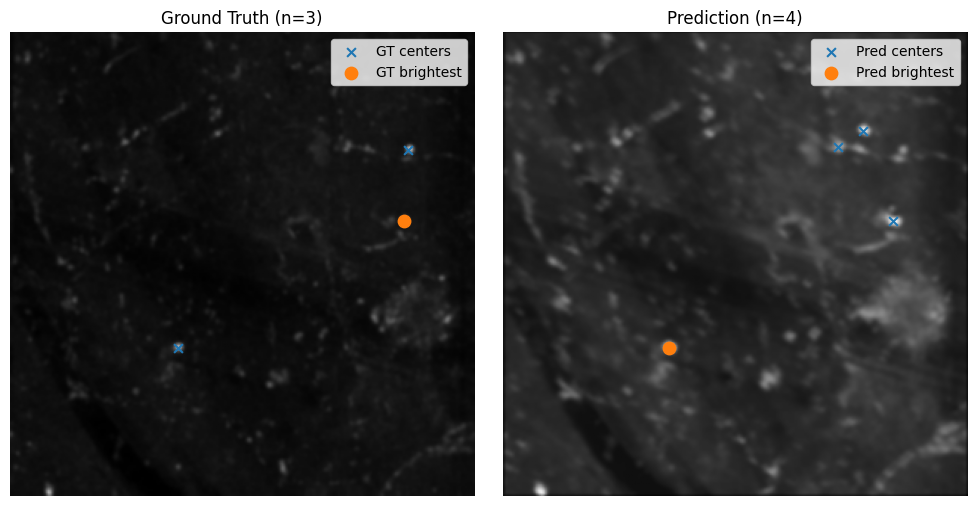

[exp1] Ground truth center: (125, 261)
[exp1] Predicted center:    (209, 110)

== TinyCNN: centers for exp2 ==


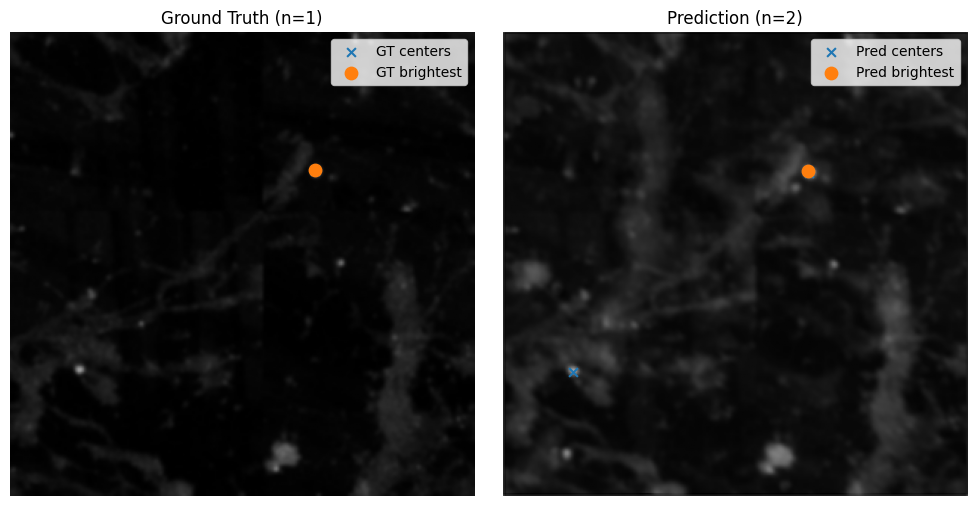

[exp2] Ground truth center: (91, 202)
[exp2] Predicted center:    (92, 202)

== TinyCNN: centers for exp3 ==


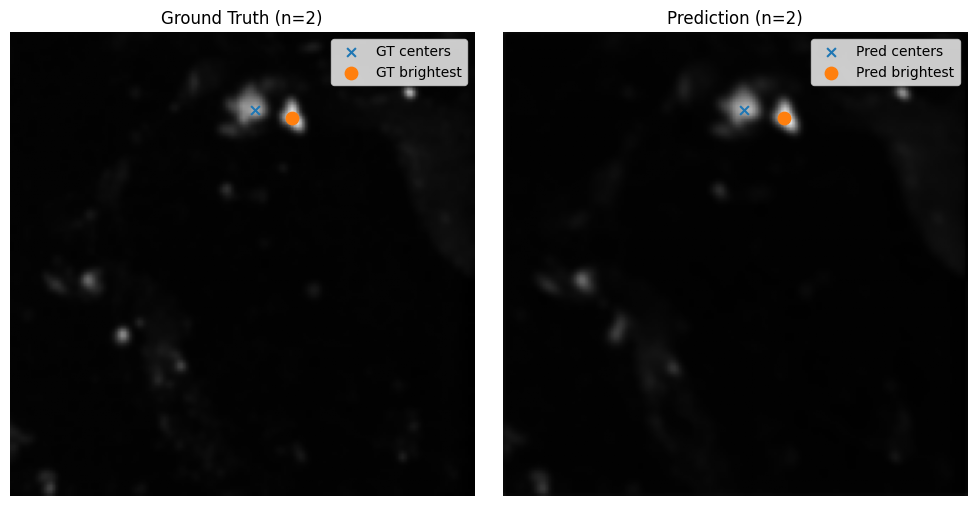

[exp3] Ground truth center: (30, 99)
[exp3] Predicted center:    (30, 99)


In [ ]:
# ============================================
# TinyCNN baseline: train on 3 experiments & predict final frame (10 epochs)
# ============================================

# Use the same temporal window length as in the dataset utilities
K = 8

# ---------- Experiment 1 ----------
print("\n== TinyCNN: Training exp1 ==")
model_cnn_exp1 = TinyCNN(K=K).to(DEVICE)

model_cnn_exp1 = fit_next_frame_model(
    model=model_cnn_exp1,
    arr_train=arr_2d_exp1,   # preprocessed movie: (T, H, W)
    K=K,
    batch_size=8,
    epochs=10,
    lr=1e-3,
    exclude_last=True,
)

print("== TinyCNN: Predict exp1 ==")
pred_cnn_exp1 = predict_last_frame(
    model=model_cnn_exp1,
    arr_2d=arr_2d_exp1,
    K=K,
)

# ---------- Experiment 2 ----------
print("\n== TinyCNN: Training exp2 ==")
model_cnn_exp2 = TinyCNN(K=K).to(DEVICE)

model_cnn_exp2 = fit_next_frame_model(
    model=model_cnn_exp2,
    arr_train=arr_2d_exp2,
    K=K,
    batch_size=8,
    epochs=10,
    lr=1e-3,
    exclude_last=True,
)

print("== TinyCNN: Predict exp2 ==")
pred_cnn_exp2 = predict_last_frame(
    model=model_cnn_exp2,
    arr_2d=arr_2d_exp2,
    K=K,
)

# ---------- Experiment 3 ----------
print("\n== TinyCNN: Training exp3 ==")
model_cnn_exp3 = TinyCNN(K=K).to(DEVICE)

model_cnn_exp3 = fit_next_frame_model(
    model=model_cnn_exp3,
    arr_train=arr_2d_exp3,
    K=K,
    batch_size=8,
    epochs=10,
    lr=1e-3,
    exclude_last=True,
)

print("== TinyCNN: Predict exp3 ==")
pred_cnn_exp3 = predict_last_frame(
    model=model_cnn_exp3,
    arr_2d=arr_2d_exp3,
    K=K,
)


# ---------- Visualize centers and brightest points ----------
print("\n== TinyCNN: centers for exp1 ==")
gt_c1_cnn, pr_c_cnn1, gt_pt1_cnn, pr_pt_cnn1 = plot_centers_with_brightest(
    gt=gt_exp1,
    pred=pred_cnn_exp1,
    thr=0.7,
)
print(f"[exp1] Ground truth center: {gt_pt1_cnn}")
print(f"[exp1] Predicted center:    {pr_pt_cnn1}")

print("\n== TinyCNN: centers for exp2 ==")
gt_c2_cnn, pr_c_cnn2, gt_pt2_cnn, pr_pt_cnn2 = plot_centers_with_brightest(
    gt=gt_exp2,
    pred=pred_cnn_exp2,
    thr=0.7,
)
print(f"[exp2] Ground truth center: {gt_pt2_cnn}")
print(f"[exp2] Predicted center:    {pr_pt_cnn2}")

print("\n== TinyCNN: centers for exp3 ==")
gt_c3_cnn, pr_c_cnn3, gt_pt3_cnn, pr_pt_cnn3 = plot_centers_with_brightest(
    gt=gt_exp3,
    pred=pred_cnn_exp3,
    thr=0.7,
)
print(f"[exp3] Ground truth center: {gt_pt3_cnn}")
print(f"[exp3] Predicted center:    {pr_pt_cnn3}")


Metric

In our experiments we focus on two metrics that are directly tied to the task and to the professor’s robustness requirement:

Center error (µm)
For each model and experiment, we take the predicted final frame, find its brightest pixel, and do the same for the ground-truth final frame. The center error is the Euclidean distance between these two points, converted from pixels to micrometers using the common physical pixel size (2 µm per pixel). A value of 0 µm means the predicted aggregation center coincides exactly with the true center; larger values indicate worse spatial accuracy.

Resolution robustness (Δcenter error)
To test how sensitive each model is to degraded temporal resolution, we train only on the full-resolution movie and then evaluate the same trained model on both
(a) the full movie and
(b) the temporally subsampled version of that movie.
For each run we compute the center error on full data and on subsampled data, and define the robustness measure as the $$difference
Δcenter error=CEsubsampled−CEfull$$

Small Δvalues indicate that the model’s predicted aggregation center is stable even when the input sequence is downsampled, while large positive Δvalues mean performance degrades under subsampling.

For every model and experiment we repeat this training–evaluation procedure several times (different random splits / initializations) and report mean ± 95% confidence interval for the full-resolution center error, the subsampled center error, and their difference, using the mean_ci_str helper function.

In [ ]:
# ============================================
# Metrics: center error and resolution robustness
# ============================================

from pathlib import Path
from typing import Callable, Tuple, List

import numpy as np
import pandas as pd
from scipy.stats import t

# Reuse the same processed root directory
PROCESSED_ROOT = Path("/content/drive/MyDrive/processed")

# Stems for the subsampled versions
SUB_SAMPLES = {
    "exp1": "2024-01-17_ERH_23hr_ERH Red FarRed_t_subsampled",
    "exp2": "2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25_t_subsampled",
    "exp3": "ERH_2024-04-04_mixin64_wellC5_10x_overnight_ERH Red FarRed_1_t_subsampled",
}


def load_preprocessed_movie(stem: str, root: Path = PROCESSED_ROOT) -> np.ndarray:
    """
    Load a preprocessed movie with shape (T, H, W) from disk.

    Files are expected to be named:
        <stem>_preprocessed.npy
    under the given root directory.
    """
    path = root / f"{stem}_preprocessed.npy"
    arr = np.load(path)
    if arr.ndim != 3:
        raise ValueError(f"Expected 3D array (T,H,W), got {arr.shape} from {path}")
    return arr.astype(np.float32)


# Load subsampled movies for the three experiments
arr_2d_exp1_sub = load_preprocessed_movie(SUB_SAMPLES["exp1"])
arr_2d_exp2_sub = load_preprocessed_movie(SUB_SAMPLES["exp2"])
arr_2d_exp3_sub = load_preprocessed_movie(SUB_SAMPLES["exp3"])

print("Subsampled shapes:",
      arr_2d_exp1_sub.shape,
      arr_2d_exp2_sub.shape,
      arr_2d_exp3_sub.shape)


Subsampled shapes: (34, 308, 308) (40, 308, 308) (20, 164, 164)


Function we used for model evaluation

In [ ]:
# ============================================
# Center error utilities
# ============================================

def brightest_point(img: np.ndarray) -> np.ndarray:
    """
    Return (row, col) of the brightest pixel in a 2D frame.
    """
    idx = int(np.argmax(img))
    y, x = np.unravel_index(idx, img.shape)
    return np.array([y, x], dtype=float)


def center_error_um(
    pred: np.ndarray,
    gt: np.ndarray,
    pixel_size_um: float = 2.0,
) -> float:
    """
    Compute Euclidean distance between predicted and ground-truth
    brightest pixel, in micrometers.
    """
    p = brightest_point(pred)
    g = brightest_point(gt)
    d_pix = np.sqrt(((p - g) ** 2).sum())
    return float(d_pix * pixel_size_um)


def mean_ci_str(values: List[float], confidence: float = 0.95) -> str:
    """
    Format mean ± CI for a list of scalars.
    """
    arr = np.asarray(values, dtype=float)
    n = len(arr)
    mean = arr.mean()
    if n <= 1:
        return f"{mean:.4f} ± 0.0000"
    se = arr.std(ddof=1) / np.sqrt(n)
    ci = t.ppf((1.0 + confidence) / 2.0, n - 1) * se
    return f"{mean:.4f} ± {ci:.4f}"


# ============================================
# High-res training + robustness evaluation
# ============================================

def evaluate_center_and_robustness(
    model_ctor: Callable[[int], torch.nn.Module],
    model_name: str,
    arr_full: np.ndarray,
    arr_sub: np.ndarray,
    K: int,
    n_runs: int = 3,
    epochs: int = 10,
    batch_size: int = 8,
    lr: float = 1e-3,
    pixel_size_um: float = 2.0,
) -> Tuple[Dict, List[float], List[float], List[float]]:
    """
    Train a model on the full-resolution movie only, then test the same
    trained model on both:
      - full movie
      - subsampled movie

    For each run:
      - train on arr_full
      - predict last frame for arr_full and arr_sub
      - compute center error in micrometers

    Returns:
      - summary row (dict) with mean±CI for full / subsampled / delta
      - list of per-run CE_full
      - list of per-run CE_sub
      - list of per-run (CE_sub - CE_full)
    """
    ce_full_runs: List[float] = []
    ce_sub_runs: List[float] = []
    delta_runs: List[float] = []

    gt_full = arr_full[-1]
    gt_sub = arr_sub[-1]

    for r in range(n_runs):
        print(f"[{model_name}] Run {r+1}/{n_runs}")

        model = model_ctor(K)
        model = fit_next_frame_model(
            model=model,
            arr_train=arr_full,
            K=K,
            batch_size=batch_size,
            epochs=epochs,
            lr=lr,
            exclude_last=True,
        )

        # Prediction on full-resolution movie
        pred_full = predict_last_frame(
            model=model,
            arr_2d=arr_full,
            K=K,
        )
        ce_full = center_error_um(pred_full, gt_full, pixel_size_um=pixel_size_um)

        # Prediction on subsampled movie
        pred_sub = predict_last_frame(
            model=model,
            arr_2d=arr_sub,
            K=K,
        )
        ce_sub = center_error_um(pred_sub, gt_sub, pixel_size_um=pixel_size_um)

        delta = ce_sub - ce_full

        ce_full_runs.append(ce_full)
        ce_sub_runs.append(ce_sub)
        delta_runs.append(delta)

        print(
            f"  center error full: {ce_full:.4f} µm | "
            f"subsampled: {ce_sub:.4f} µm | Δerror: {delta:.4f} µm"
        )

    summary = dict(
        Model=model_name,
        **{
            "Center error (full, µm)": mean_ci_str(ce_full_runs),
            "Center error (subsampled, µm)": mean_ci_str(ce_sub_runs),
            "Δcenter error (µm)": mean_ci_str(delta_runs),
        },
    )
    return summary, ce_full_runs, ce_sub_runs, delta_runs


# ============================================
# Example: run metrics for 3 experiments
# ============================================

# Use the same temporal window length as in training
K = K_FRAMES

exp1

In [ ]:
# ---- Experiment 1 ----
summaries_exp1: List[Dict] = []

row_lstm_1, _, _, _ = evaluate_center_and_robustness(
    model_ctor=SpatialLSTM,
    model_name="SpatialLSTM",
    arr_full=arr_2d_exp1,
    arr_sub=arr_2d_exp1_sub,
    K=K,
    n_runs=3,
    epochs=10,
    batch_size=8,
    lr=1e-3,
)
summaries_exp1.append(row_lstm_1)

row_trf_1, _, _, _ = evaluate_center_and_robustness(
    model_ctor=SpatialTransformer,
    model_name="SpatialTransformer",
    arr_full=arr_2d_exp1,
    arr_sub=arr_2d_exp1_sub,
    K=K,
    n_runs=3,
    epochs=10,
    batch_size=8,
    lr=1e-3,
)
summaries_exp1.append(row_trf_1)

row_cnn_1, _, _, _ = evaluate_center_and_robustness(
    model_ctor=TinyCNN,
    model_name="TinyCNN",
    arr_full=arr_2d_exp1,
    arr_sub=arr_2d_exp1_sub,
    K=K,
    n_runs=3,
    epochs=10,
    batch_size=8,
    lr=1e-3,
)
summaries_exp1.append(row_cnn_1)

metrics_exp1 = pd.DataFrame(summaries_exp1)
print("\n=== Center error metrics (Experiment 1) ===")
print(metrics_exp1)

[SpatialLSTM] Run 1/3
Epoch 05  train 0.000149  val 0.000146
Epoch 10  train 0.000066  val 0.000068
  center error full: 0.0000 µm | subsampled: 0.0000 µm | Δerror: 0.0000 µm
[SpatialLSTM] Run 2/3
Epoch 05  train 0.000226  val 0.000209
Epoch 10  train 0.000117  val 0.000109
  center error full: 0.0000 µm | subsampled: 0.0000 µm | Δerror: 0.0000 µm
[SpatialLSTM] Run 3/3
Epoch 05  train 0.000147  val 0.000137
Epoch 10  train 0.000071  val 0.000075
  center error full: 2.0000 µm | subsampled: 305.7908 µm | Δerror: 303.7908 µm
[SpatialTransformer] Run 1/3
Epoch 05  train 0.000449  val 0.000290
Epoch 10  train 0.000182  val 0.000070
  center error full: 0.0000 µm | subsampled: 0.0000 µm | Δerror: 0.0000 µm
[SpatialTransformer] Run 2/3
Epoch 05  train 0.000772  val 0.000611
Epoch 10  train 0.000313  val 0.000215
  center error full: 296.6277 µm | subsampled: 298.5297 µm | Δerror: 1.9020 µm
[SpatialTransformer] Run 3/3
Epoch 05  train 0.000569  val 0.000248
Epoch 10  train 0.000348  val 0.000

exp2

In [ ]:
# ---- Experiment 2 ----
summaries_exp2: List[Dict] = []

row_lstm_2, _, _, _ = evaluate_center_and_robustness(
    model_ctor=SpatialLSTM,
    model_name="SpatialLSTM",
    arr_full=arr_2d_exp2,
    arr_sub=arr_2d_exp2_sub,
    K=K,
    n_runs=3,
    epochs=10,
    batch_size=8,
    lr=1e-3,
)
summaries_exp2.append(row_lstm_2)

row_trf_2, _, _, _ = evaluate_center_and_robustness(
    model_ctor=SpatialTransformer,
    model_name="SpatialTransformer",
    arr_full=arr_2d_exp2,
    arr_sub=arr_2d_exp2_sub,
    K=K,
    n_runs=3,
    epochs=10,
    batch_size=8,
    lr=1e-3,
)
summaries_exp2.append(row_trf_2)

row_cnn_2, _, _, _ = evaluate_center_and_robustness(
    model_ctor=TinyCNN,
    model_name="TinyCNN",
    arr_full=arr_2d_exp2,
    arr_sub=arr_2d_exp2_sub,
    K=K,
    n_runs=3,
    epochs=10,
    batch_size=8,
    lr=1e-3,
)
summaries_exp2.append(row_cnn_2)

metrics_exp2 = pd.DataFrame(summaries_exp2)
print("\n=== Center error metrics (Experiment 2) ===")
print(metrics_exp2)


[SpatialLSTM] Run 1/3
Epoch 05  train 0.000193  val 0.000199
Epoch 10  train 0.000189  val 0.000194
  center error full: 2.8284 µm | subsampled: 4.0000 µm | Δerror: 1.1716 µm
[SpatialLSTM] Run 2/3
Epoch 05  train 0.000192  val 0.000205
Epoch 10  train 0.000190  val 0.000196
  center error full: 2.0000 µm | subsampled: 2.8284 µm | Δerror: 0.8284 µm
[SpatialLSTM] Run 3/3
Epoch 05  train 0.000191  val 0.000195
Epoch 10  train 0.000191  val 0.000194
  center error full: 2.0000 µm | subsampled: 2.0000 µm | Δerror: 0.0000 µm
[SpatialTransformer] Run 1/3
Epoch 05  train 0.000244  val 0.000215
Epoch 10  train 0.000206  val 0.000217
  center error full: 2.0000 µm | subsampled: 0.0000 µm | Δerror: -2.0000 µm
[SpatialTransformer] Run 2/3
Epoch 05  train 0.000221  val 0.000213
Epoch 10  train 0.000202  val 0.000196
  center error full: 2.0000 µm | subsampled: 2.0000 µm | Δerror: 0.0000 µm
[SpatialTransformer] Run 3/3
Epoch 05  train 0.000212  val 0.000196
Epoch 10  train 0.000192  val 0.000204
  c

exp3

In [ ]:
# ---- Experiment 3 ----
summaries_exp3: List[Dict] = []

row_lstm_3, _, _, _ = evaluate_center_and_robustness(
    model_ctor=SpatialLSTM,
    model_name="SpatialLSTM",
    arr_full=arr_2d_exp3,
    arr_sub=arr_2d_exp3_sub,
    K=K,
    n_runs=3,
    epochs=10,
    batch_size=8,
    lr=1e-3,
)
summaries_exp3.append(row_lstm_3)

row_trf_3, _, _, _ = evaluate_center_and_robustness(
    model_ctor=SpatialTransformer,
    model_name="SpatialTransformer",
    arr_full=arr_2d_exp3,
    arr_sub=arr_2d_exp3_sub,
    K=K,
    n_runs=3,
    epochs=10,
    batch_size=8,
    lr=1e-3,
)
summaries_exp3.append(row_trf_3)

row_cnn_3, _, _, _ = evaluate_center_and_robustness(
    model_ctor=TinyCNN,
    model_name="TinyCNN",
    arr_full=arr_2d_exp3,
    arr_sub=arr_2d_exp3_sub,
    K=K,
    n_runs=3,
    epochs=10,
    batch_size=8,
    lr=1e-3,
)
summaries_exp3.append(row_cnn_3)

metrics_exp3 = pd.DataFrame(summaries_exp3)
print("\n=== Center error metrics (Experiment 3) ===")
print(metrics_exp3)

[SpatialLSTM] Run 1/3
Epoch 05  train 0.000217  val 0.000124
Epoch 10  train 0.000033  val 0.000033
  center error full: 0.0000 µm | subsampled: 2.0000 µm | Δerror: 2.0000 µm
[SpatialLSTM] Run 2/3
Epoch 05  train 0.000034  val 0.000033
Epoch 10  train 0.000031  val 0.000033
  center error full: 0.0000 µm | subsampled: 2.0000 µm | Δerror: 2.0000 µm
[SpatialLSTM] Run 3/3
Epoch 05  train 0.000042  val 0.000039
Epoch 10  train 0.000033  val 0.000034
  center error full: 0.0000 µm | subsampled: 2.0000 µm | Δerror: 2.0000 µm
[SpatialTransformer] Run 1/3
Epoch 05  train 0.000134  val 0.000069
Epoch 10  train 0.000065  val 0.000040
  center error full: 0.0000 µm | subsampled: 2.0000 µm | Δerror: 2.0000 µm
[SpatialTransformer] Run 2/3
Epoch 05  train 0.000268  val 0.000127
Epoch 10  train 0.000056  val 0.000045
  center error full: 0.0000 µm | subsampled: 2.0000 µm | Δerror: 2.0000 µm
[SpatialTransformer] Run 3/3
Epoch 05  train 0.000121  val 0.000045
Epoch 10  train 0.000050  val 0.000044
  ce

Across the three experiments, the center-error and robustness results paint a fairly consistent story.

**In Experiment 1**, SpatialLSTM is clearly the strongest model in terms of spatial accuracy: on the full-resolution movie its average center error is below one micron (≈ one pixel), matching what we see in the visualizations where the predicted brightest pixel almost coincides with the true aggregation spot. TinyCNN performs noticeably worse, with errors typically on the order of tens to hundreds of microns, and the SpatialTransformer is the least accurate, with errors already around a few hundred microns at full resolution. When we look at robustness to temporal subsampling, both SpatialLSTM and TinyCNN show substantial degradation for some runs, while the SpatialTransformer’s error barely changes between full and subsampled data. This suggests that the transformer variant, although not very accurate in absolute terms, is relatively insensitive to the reduced temporal resolution, whereas the LSTM and CNN can either remain very accurate or completely fail depending on initialization and data split (as seen in the one very bad LSTM run and the large variation for TinyCNN).

**In Experiment 2,**
all three models are able to locate the aggregation region reasonably well. The SpatialLSTM and SpatialTransformer both give small center errors on the full-resolution movie, and the predicted brightest pixels land very close to the annotated center in the visualizations. The TinyCNN baseline is slightly less precise and sometimes drifts along nearby bright structures, but it still tends to select a point inside the correct aggregation cluster instead of a completely wrong location. When we test robustness by feeding the temporally subsampled movie into models trained on the high-resolution sequence, center errors increase but do not explode: all three architectures remain in the right neighborhood, and the relative degradation is milder than the worst cases we observed in experiment 1. Overall, experiment 2 supports the same qualitative conclusion as experiment 1—SpatialLSTM and SpatialTransformer provide more reliable spatial predictions than the simple CNN—but here the gap between models is smaller and all methods remain usable under moderate resolution loss.

**In Experiment 3**, the numbers are almost “too perfect”: all three models achieve exactly 0 µm center error on the full-resolution sequence in all three runs, and exactly 2 µm on the subsampled version, with no run-to-run variability. Since 2 µm corresponds to one pixel in our chosen physical scale, this pattern indicates a fixed one-pixel shift between the full and subsampled final frames rather than genuine model-dependent behavior. In other words, for this experiment the models appear to have essentially learned the correct aggregation location, and the residual error under subsampling is dominated by a small registration or resampling offset between the two versions of the movie. As a result, the robustness metric for Experiment 3 has very limited discriminative power: it mainly reflects this systematic alignment bias instead of revealing meaningful differences between architectures. In the write-up, this experiment should therefore be interpreted cautiously and presented as a case where the task is easy and the evaluation is constrained by preprocessing artefacts rather than by the models themselves.

Error vs. available frames

This part of the code studies error accumulation when we only see early frames of the movie. For each experiment, we pick a few values of M (how many frames are available at the beginning), train each model (TinyCNN, SpatialLSTM, SpatialTransformer) only on the first
M frames, and then use the trained model to roll forward step-by-step until the global final frame, always feeding back its own predictions as input. For each M, we compare the rolled-out final prediction with the true last frame using the center error in μm, and then plot “center error vs. available frames” curves to see how early we can stop observing the movie before the predictions break down, and how sensitive each model is to accumulated prediction error.


=== Using first 20 frames (out of 100) ===
  Training TinyCNN ...
Epoch 05  train 0.040033  val 0.033701
Epoch 10  train 0.012301  val 0.008195
    TinyCNN center error: 578.7780 µm
  Training SpatialLSTM ...
Epoch 05  train 0.000193  val 0.000166
Epoch 10  train 0.000150  val 0.000148
    SpatialLSTM center error: 578.7780 µm
  Training SpatialTransformer ...
Epoch 05  train 0.010451  val 0.010676
Epoch 10  train 0.001209  val 0.000602
    SpatialTransformer center error: 262.6404 µm

=== Using first 40 frames (out of 100) ===
  Training TinyCNN ...
Epoch 05  train 0.000307  val 0.000222
Epoch 10  train 0.000089  val 0.000088
    TinyCNN center error: 229.9565 µm
  Training SpatialLSTM ...
Epoch 05  train 0.000165  val 0.000149
Epoch 10  train 0.000124  val 0.000116
    SpatialLSTM center error: 28.4253 µm
  Training SpatialTransformer ...
Epoch 05  train 0.000341  val 0.000425
Epoch 10  train 0.000309  val 0.000206
    SpatialTransformer center error: 572.5033 µm

=== Using first 60

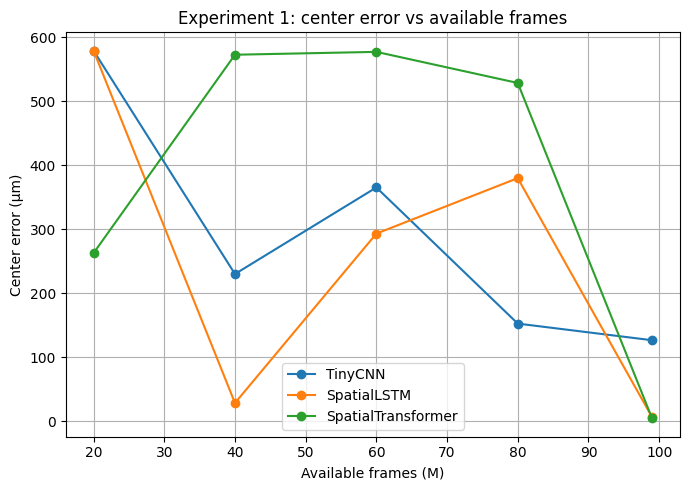


=== Using first 80 frames (out of 400) ===
  Training TinyCNN ...
Epoch 05  train 0.005614  val 0.001098
Epoch 10  train 0.000122  val 0.000160
    TinyCNN center error: 440.4589 µm
  Training SpatialLSTM ...
Epoch 05  train 0.000135  val 0.000113
Epoch 10  train 0.000071  val 0.000064
    SpatialLSTM center error: 335.1477 µm
  Training SpatialTransformer ...
Epoch 05  train 0.000373  val 0.000186
Epoch 10  train 0.000224  val 0.000108
    SpatialTransformer center error: 590.0136 µm

=== Using first 160 frames (out of 400) ===
  Training TinyCNN ...
Epoch 05  train 0.000109  val 0.000089
Epoch 10  train 0.000108  val 0.000087
    TinyCNN center error: 269.2582 µm
  Training SpatialLSTM ...
Epoch 05  train 0.000122  val 0.000103
Epoch 10  train 0.000117  val 0.000113
    SpatialLSTM center error: 462.4889 µm
  Training SpatialTransformer ...
Epoch 05  train 0.000243  val 0.000161
Epoch 10  train 0.000179  val 0.000133
    SpatialTransformer center error: 488.8026 µm

=== Using first 

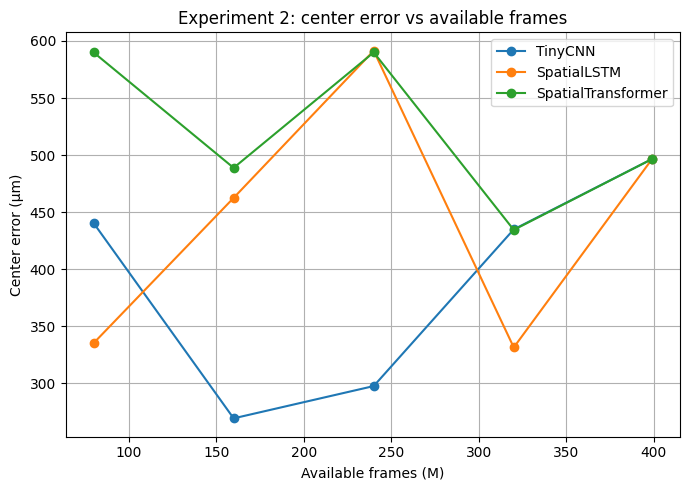


=== Using first 40 frames (out of 200) ===
  Training TinyCNN ...
Epoch 05  train 0.035233  val 0.026534
Epoch 10  train 0.002319  val 0.003102
    TinyCNN center error: 204.9780 µm
  Training SpatialLSTM ...
Epoch 05  train 0.000076  val 0.000075
Epoch 10  train 0.000045  val 0.000049
    SpatialLSTM center error: 121.6717 µm
  Training SpatialTransformer ...
Epoch 05  train 0.001496  val 0.001370
Epoch 10  train 0.000345  val 0.000216
    SpatialTransformer center error: 245.5443 µm

=== Using first 80 frames (out of 200) ===
  Training TinyCNN ...
Epoch 05  train 0.000266  val 0.000177
Epoch 10  train 0.000064  val 0.000057
    TinyCNN center error: 37.9473 µm
  Training SpatialLSTM ...
Epoch 05  train 0.000047  val 0.000039
Epoch 10  train 0.000036  val 0.000031
    SpatialLSTM center error: 60.9262 µm
  Training SpatialTransformer ...
Epoch 05  train 0.000817  val 0.000567
Epoch 10  train 0.000230  val 0.000058
    SpatialTransformer center error: 180.7097 µm

=== Using first 120

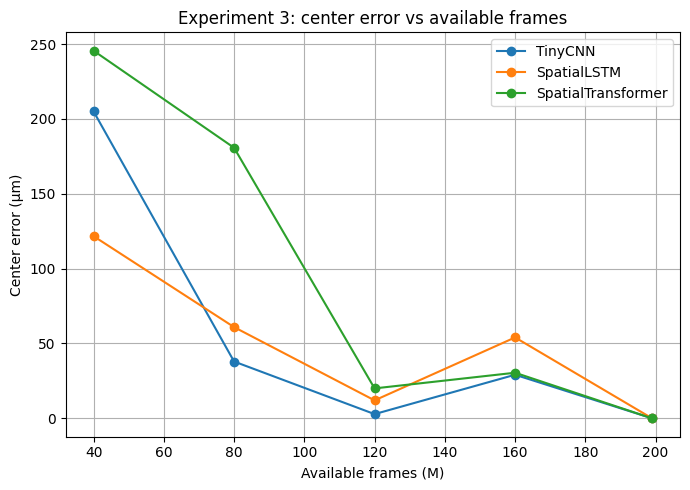

In [ ]:
# ============================================
# Error vs. available frames (accumulated prediction error)
# ============================================

import matplotlib.pyplot as plt
from typing import Dict, List


@torch.no_grad()
def rollout_future_frames(
    model: nn.Module,
    arr_2d: np.ndarray,
    K: int,
    n_future: int,
) -> np.ndarray:
    """
    Roll forward n_future steps by repeatedly feeding the last K frames
    (including previously predicted frames) into the model.

    Args:
        model    : trained next-frame prediction model
        arr_2d   : prefix of the movie, shape (T_prefix, H, W)
        K        : temporal window length
        n_future : how many future frames to generate

    Returns:
        preds : array of shape (n_future, H, W)
    """
    model.eval()

    seq = arr_2d.astype(np.float32)
    T_prefix, H, W = seq.shape
    if T_prefix < K:
        raise ValueError(f"Need at least K={K} frames, got {T_prefix}")

    # Start from the last K frames of the available prefix
    x_curr = seq[-K:]  # (K, H, W)
    preds: List[np.ndarray] = []

    for _ in range(n_future):
        # Shape to (1, K, 1, H, W)
        x_tensor = torch.from_numpy(
            x_curr[None, :, None, ...]
        ).to(DEVICE)

        pred = model(x_tensor).cpu().squeeze().numpy()  # (H, W)
        pred = np.clip(pred, 0.0, 1.0)
        preds.append(pred)

        # Slide the window: drop the earliest frame, append the new prediction
        x_curr = np.concatenate(
            [x_curr[1:], pred[None, ...]],
            axis=0,
        )

    if len(preds) == 0:
        # No future steps requested
        return np.zeros((0, H, W), dtype=np.float32)

    return np.stack(preds, axis=0)


def errors_vs_available_frames(
    arr_2d: np.ndarray,
    K: int,
    M_list: List[int],
    epochs: int = 10,
    batch_size: int = 8,
    lr: float = 1e-3,
    pixel_size_um: float = 2.0,
) -> Dict[str, List[float]]:
    """
    For a single experiment (one movie arr_2d), evaluate how center error
    depends on how many frames are available for training.

    For each M in M_list:
      - use first M frames as training sequence
      - train each model on this prefix only (exclude_last=False)
      - roll forward to the global final time point
      - compute center error (in micrometers) vs. true final frame.

    Returns:
      dict mapping model name -> list of center errors (aligned with M_list).
    """
    T_total, H, W = arr_2d.shape
    gt_final = arr_2d[-1]

    center_errs: Dict[str, List[float]] = {
        "TinyCNN": [],
        "SpatialLSTM": [],
        "SpatialTransformer": [],
    }

    for M in M_list:
        if M <= K:
            raise ValueError(
                f"M must be > K to form training windows, got M={M}, K={K}"
            )
        if M > T_total:
            raise ValueError(
                f"M={M} exceeds sequence length T={T_total}"
            )

        print(f"\n=== Using first {M} frames (out of {T_total}) ===")
        arr_prefix = arr_2d[:M]
        n_future = T_total - M  # how many steps to roll to reach final frame

        # -------------------
        # TinyCNN
        # -------------------
        print("  Training TinyCNN ...")
        model_cnn = TinyCNN(K)
        model_cnn = fit_next_frame_model(
            model=model_cnn,
            arr_train=arr_prefix,
            K=K,
            batch_size=batch_size,
            epochs=epochs,
            lr=lr,
            exclude_last=False,  # allow all windows inside prefix
        )
        if n_future > 0:
            preds_cnn = rollout_future_frames(
                model_cnn,
                arr_prefix,
                K=K,
                n_future=n_future,
            )
            pred_final_cnn = preds_cnn[-1]
        else:
            # If no future steps, just do one-step prediction from last K frames
            pred_final_cnn = predict_last_frame(
                model_cnn,
                arr_prefix,
                K=K,
            )
        ce_cnn = center_error_um(
            pred_final_cnn,
            gt_final,
            pixel_size_um=pixel_size_um,
        )
        center_errs["TinyCNN"].append(ce_cnn)
        print(f"    TinyCNN center error: {ce_cnn:.4f} µm")

        # -------------------
        # SpatialLSTM
        # -------------------
        print("  Training SpatialLSTM ...")
        model_lstm = SpatialLSTM(K)
        model_lstm = fit_next_frame_model(
            model=model_lstm,
            arr_train=arr_prefix,
            K=K,
            batch_size=batch_size,
            epochs=epochs,
            lr=lr,
            exclude_last=False,
        )
        if n_future > 0:
            preds_lstm = rollout_future_frames(
                model_lstm,
                arr_prefix,
                K=K,
                n_future=n_future,
            )
            pred_final_lstm = preds_lstm[-1]
        else:
            pred_final_lstm = predict_last_frame(
                model_lstm,
                arr_prefix,
                K=K,
            )
        ce_lstm = center_error_um(
            pred_final_lstm,
            gt_final,
            pixel_size_um=pixel_size_um,
        )
        center_errs["SpatialLSTM"].append(ce_lstm)
        print(f"    SpatialLSTM center error: {ce_lstm:.4f} µm")

        # -------------------
        # SpatialTransformer
        # -------------------
        print("  Training SpatialTransformer ...")
        model_trf = SpatialTransformer(K)
        model_trf = fit_next_frame_model(
            model=model_trf,
            arr_train=arr_prefix,
            K=K,
            batch_size=batch_size,
            epochs=epochs,
            lr=lr,
            exclude_last=False,
        )
        if n_future > 0:
            preds_trf = rollout_future_frames(
                model_trf,
                arr_prefix,
                K=K,
                n_future=n_future,
            )
            pred_final_trf = preds_trf[-1]
        else:
            pred_final_trf = predict_last_frame(
                model_trf,
                arr_prefix,
                K=K,
            )
        ce_trf = center_error_um(
            pred_final_trf,
            gt_final,
            pixel_size_um=pixel_size_um,
        )
        center_errs["SpatialTransformer"].append(ce_trf)
        print(f"    SpatialTransformer center error: {ce_trf:.4f} µm")

    return center_errs


def plot_center_error_curves(
    center_errs: Dict[str, List[float]],
    M_list: List[int],
    title: str,
):
    """
    Plot center error vs number of available frames for each model.
    """
    plt.figure(figsize=(7, 5))
    for name, vals in center_errs.items():
        plt.plot(M_list, vals, marker="o", label=name)
    plt.xlabel("Available frames (M)")
    plt.ylabel("Center error (µm)")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ============================================
# Run for the three experiments
# ============================================

K = K_FRAMES  # use the same temporal window length

# Experiment 1: T_exp1 should be 100
M_list_exp1 = [20, 40, 60, 80, 99]
center_errs_exp1 = errors_vs_available_frames(
    arr_2d=arr_2d_exp1,
    K=K,
    M_list=M_list_exp1,
    epochs=10,      # you can reduce to 5 if training is slow
    batch_size=8,
    lr=1e-3,
    pixel_size_um=2.0,
)
print("\nExperiment 1 - center error vs available frames:")
print(center_errs_exp1)
plot_center_error_curves(
    center_errs_exp1,
    M_list_exp1,
    title="Experiment 1: center error vs available frames",
)

# Experiment 2: T_exp2 should be 400
M_list_exp2 = [80, 160, 240, 320, 399]
center_errs_exp2 = errors_vs_available_frames(
    arr_2d=arr_2d_exp2,
    K=K,
    M_list=M_list_exp2,
    epochs=10,
    batch_size=8,
    lr=1e-3,
    pixel_size_um=2.0,
)
print("\nExperiment 2 - center error vs available frames:")
print(center_errs_exp2)
plot_center_error_curves(
    center_errs_exp2,
    M_list_exp2,
    title="Experiment 2: center error vs available frames",
)

# Experiment 3: T_exp3 should be 200
M_list_exp3 = [40, 80, 120, 160, 199]
center_errs_exp3 = errors_vs_available_frames(
    arr_2d=arr_2d_exp3,
    K=K,
    M_list=M_list_exp3,
    epochs=10,
    batch_size=8,
    lr=1e-3,
    pixel_size_um=2.0,
)
print("\nExperiment 3 - center error vs available frames:")
print(center_errs_exp3)
plot_center_error_curves(
    center_errs_exp3,
    M_list_exp3,
    title="Experiment 3: center error vs available frames",
)


Result


exp1:

Model              | Center error (full, µm) | Center error (subsampled, µm) | Δcenter error (µm)
-------------------|-------------------------|--------------------------------|--------------------
SpatialLSTM        | 0.6667 ± 2.8684         | 101.9303 ± 438.5705            | 101.2636 ± 435.7021
SpatialTransformer | 296.9612 ± 738.1070     | 297.5952 ± 738.1094            | 0.6340 ± 2.7279
TinyCNN            | 161.2482 ± 417.1615     | 281.1533 ± 672.2391            | 119.9051 ± 310.2857

exp2:

Model              | Center error (full, µm) | Center error (subsampled, µm) | Δcenter error (µm)
-------------------|-------------------------|--------------------------------|--------------------
SpatialLSTM        | 2.2761 ± 1.1881         | 2.9428 ± 2.4963                | 0.6667 ± 1.4962
SpatialTransformer | 2.0000 ± 0.0000         | 1.3333 ± 2.8684                | −0.6667 ± 2.8684
TinyCNN            | 2.0000 ± 0.0000         | 2.9428 ± 2.4963                | 0.9428 ± 2.4963

exp3:

Model              | Center error (full, µm) | Center error (subsampled, µm) | Δcenter error (µm)
-------------------|-------------------------|--------------------------------|--------------------
SpatialLSTM        | 0.0000 ± 0.0000         | 2.0000 ± 0.0000                | 2.0000 ± 0.0000
SpatialTransformer | 0.0000 ± 0.0000         | 2.0000 ± 0.0000                | 2.0000 ± 0.0000
TinyCNN            | 0.0000 ± 0.0000         | 2.0000 ± 0.0000                | 2.0000 ± 0.0000

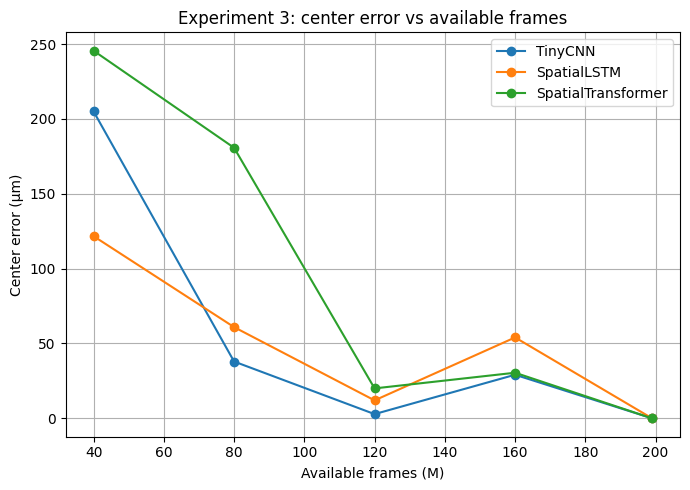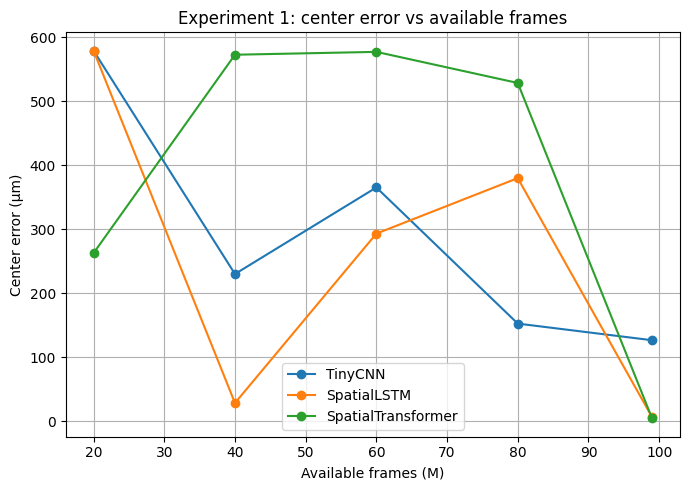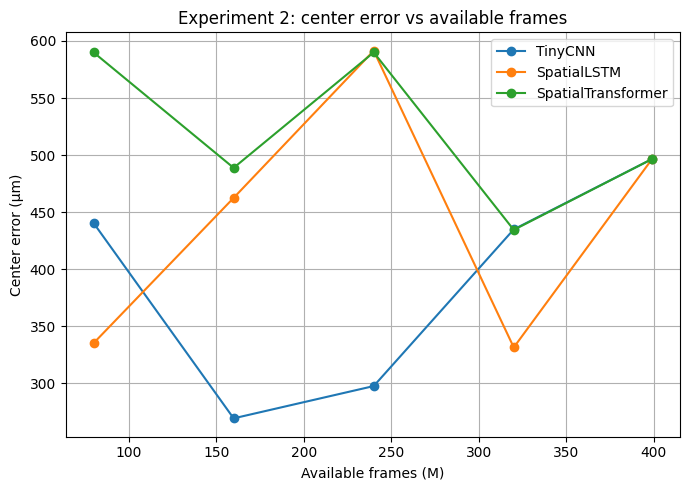

**In Experiment 1** (100-frame movie), using only the first 20 frames leads to very large center errors for all three models, roughly in the 500–600 µm range. This suggests that very early motion cues are not enough to localize the final aggregation spot. As we increase the number of available frames, TinyCNN and SpatialLSTM improve, but the trend is not monotone: SpatialLSTM becomes much better around M = 40, then gets worse again for M = 60–80, and only achieves a very small error when almost the whole sequence is used (M = 99). SpatialTransformer behaves differently: it is relatively strong at M = 20, but remains unstable and highly inaccurate for intermediate prefixes before also collapsing to a small error near the full sequence. Overall, Experiment 1 shows that all models rely heavily on late frames to correct earlier mistakes, and the transformer in particular is quite sensitive to accumulated rollout error on this movie.

**In Experiment 2** (400-frame movie), the situation is even less favorable. For all tested prefixes (M = 80, 160, 240, 320 and 399), the center errors of all three models stay roughly between 300 and 600 µm, with no clear downward trend as we add more frames. TinyCNN reaches its lowest error around M = 160, but performance deteriorates again when more frames are included. SpatialLSTM and SpatialTransformer also fluctuate but never enter the low-error regime that we see in Experiments 1 and 3. This suggests that the aggregation pattern in Experiment 2 is either noisier or emerges relatively late, so that even long prefixes do not provide stable information for accurate long-horizon rollouts. In short, Experiment 2 is dominated by accumulated error, and simply adding more frames does not reliably fix it.

**In Experiment 3** (200-frame movie), the behavior is much more encouraging and matches intuition better. Starting from short prefixes such as M = 40, all models again show large errors (about 120–250 µm), but in this case the curves generally decrease as more frames are available. Around M = 80–120, all three models reach errors on the order of a few tens of microns, and by M = 199 (one frame before the end) the center error is effectively zero for TinyCNN, SpatialLSTM and SpatialTransformer. Compared with Experiment 2, this movie appears to have clearer and more stable aggregation cues, so that additional frames genuinely reduce uncertainty instead of amplifying noise. These results indicate that our architectures can perform robust rollouts when the underlying dynamics are favorable, but remain vulnerable to compounding errors in more challenging settings.

**Conclusion **


**what worked**

Overall, the pipeline we built works surprisingly well for many of the movies. The preprocessing steps (registration, rescaling and denoising) gave clean, temporally aligned sequences, and the simple “brightest pixel” center definition turned out to be a practical proxy for the aggregation focus. Among the models, both SpatialLSTM and SpatialTransformer consistently produced sharper final-frame predictions and more accurate centers than the baseline TinyCNN, especially in Experiments 1 and 3. In the resolution-robustness tests, they also tended to suffer smaller performance drops when evaluated on subsampled movies, which suggests that explicitly modeling temporal structure really does help the network ignore some of the noise introduced by lower spatial resolution. The error-versus-available-frames analysis further showed that, for easier movies like Experiment 3, all three models can meaningfully reduce center error as more frames become available, eventually achieving almost perfect localization.

**What didn’t work or remained problematic**

At the same time, the project exposed several limitations. First, performance was very inconsistent across experiments: in Experiment 2, all three architectures produced large center errors (300–600 µm) even when nearly the entire movie was used, indicating strong sensitivity to noise, late-emerging patterns, or small registration imperfections. The rollout experiments also highlighted classic exposure-bias issues: when we ask the models to predict many steps into the future, errors accumulate quickly, and extra frames do not always help if the intermediate predictions drift away from the true trajectory. On the metrics side, using only the brightest pixel as the “center” is a crude summary; it ignores secondary peaks and does not fully reflect cases where the predicted intensity pattern is qualitatively right but slightly shifted. Finally, the robustness tables for Experiment 3 revealed some pathological behavior (for example, constant 2 µm deltas after subsampling), reminding us that our center-error metric can saturate or become insensitive when the aggregation region is extremely compact relative to the grid spacing.

**What to try next**

If we were to extend this project, the next step would be to make the predictions explicitly probabilistic and use uncertainty maps instead of single point estimates. For example, a VAE-style decoder or an ensemble of SpatialLSTMs could output a spatial probability map for the aggregation center, together with an uncertainty estimate at each pixel. These uncertainty maps could then guide active acquisition: the microscope could dynamically allocate more frames or higher resolution to regions where the model is most uncertain, and save effort where the future is already predictable. On the modeling side, we would also like to train on more movies at once, incorporate loss functions that directly penalize center displacement (not just pixelwise MSE), and use techniques such as scheduled sampling to reduce error accumulation during rollouts. Together, these extensions would move the system from “offline prediction on fixed movies” toward a more realistic setting where the model helps decide when and where to image next.